In [12]:
from sklearn.svm import LinearSVC
from glob import glob
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from functools import partial
from sklearn.model_selection import KFold, ShuffleSplit, TimeSeriesSplit
from sklearn.utils import resample

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, librosa as lr
sns.set()

### ***Inspecting the classification data***

Hearts normally have a predictable sound pattern as they beat, but some disorders can cause the heart to beat abnormally. This dataset contains a training set with labels for each type of heartbeat, and a testing set with no labels. You'll use the testing set to validate your models.

As you have labeled data, this dataset is ideal for classification. 

* Use **`glob`** to return a list of the `.wav` files in current directory.
* Import the first audio file in the list using **`librosa`**.
* Generate a `time` array for the data.
* Plot the waveform for this file, along with the time array.

In [ ]:
import librosa as lr
from glob import glob

# List all the wav files in the folder
audio_files = glob(data_dir + '/*.wav')



```
['./files/murmur__201108222238.wav',
 './files/murmur__201108222242.wav',
 './files/murmur__201108222243.wav',
 './files/murmur__201108222245.wav',
 './files/murmur__201108222246.wav',
 './files/murmur__201108222248.wav',
 './files/murmur__201108222251.wav',
 './files/murmur__201108222252.wav',
 './files/murmur__201108222253.wav',
 './files/murmur__201108222255.wav',
 './files/murmur__201108222256.wav',
 './files/murmur__201108222258.wav',
 './files/normal__201101070538.wav',
 './files/normal__201101151127.wav',
 './files/normal__201102081152.wav',
 './files/normal__201102081321.wav',
 './files/normal__201102201230.wav',
 './files/normal__201102260502.wav',
 './files/normal__201102270940.wav',
 './files/normal__201103090635.wav',
 './files/normal__201103101140.wav']
```



In [ ]:
# Read in the first audio file, create the time array
audio, sfreq = lr.load('./files/murmur__201108222238.wav')
time = np.arange(0, len(audio)) / sfreq

# Plot audio over time
fig, ax = plt.subplots()
ax.plot(time, audio)
ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')
plt.show()

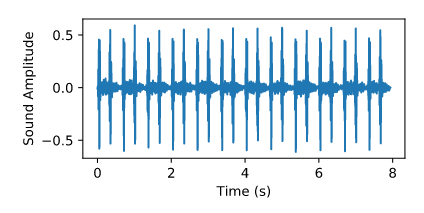

 There are several seconds of heartbeat sounds in here, though note that most of this time is silence. 

### ***Inspecting the regression data***

The next dataset contains information about company market value over several years of time. This is one of the most popular kind of time series data used for regression. If you can model the value of a company as it changes over time, you can make predictions about where that company will be in the future. 

In this exercise, you'll plot the time series for a number of companies to get an understanding of how they are (or aren't) related to one another.

* Import the data with Pandas (stored in the file `'prices.csv'`).
* Convert the index of `data` to `datetime`.
* Loop through each column of `data` and plot the the column's values over time.

                  AAPL  FB       NFLX          V        XOM
date                                                       
2010-01-04  214.009998 NaN  53.479999  88.139999  69.150002
2010-01-05  214.379993 NaN  51.510001  87.129997  69.419998
2010-01-06  210.969995 NaN  53.319999  85.959999  70.019997
2010-01-07  210.580000 NaN  52.400001  86.760002  69.800003
2010-01-08  211.980005 NaN  53.300002  87.000000  69.519997


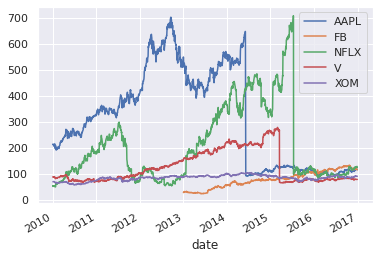

In [ ]:
# Read in the data
data = pd.read_csv('prices.csv', index_col=0).drop(columns='volume')

# Convert the index of the DataFrame to datetime
data.index = pd.to_datetime(data.index)
sublist = ['AAPL',  'FB', 'NFLX', 'V', 'XOM']
data = data.query("symbol == @sublist")
g = data.groupby('symbol')
temp = []
AAPL, FB, NFLX, V, XOM = g.get_group('AAPL'), g.get_group('FB'), g.get_group('NFLX'), g.get_group('V'), g.get_group('XOM')
for i, j in zip([AAPL, FB, NFLX, V, XOM], sublist):
    i = i.rename(columns={'close': j})
    i.drop(columns='symbol', inplace=True)
    temp.append(i)
data = pd.concat(temp, axis=1)    
print(data.head())

# Loop through each column, plot its values over time
fig, ax = plt.subplots()
for column in data:
    data[column].plot(ax=ax, label=column)
ax.legend()
plt.show()

Note that each company's value is sometimes correlated with others, and sometimes not. Also note there are a lot of 'jumps' in there - what effect do you think these jumps would have on a predictive model?

### ***Many repetitions of sounds***

In this exercise, you'll start with perhaps the simplest classification technique: averaging across dimensions of a dataset and visually inspecting the result.

You'll use the heartbeat data described in the last chapter. Some recordings are normal heartbeat activity, while others are abnormal activity. Let's see if you can spot the difference.

Two DataFrames, `normal` and `abnormal`, each with the shape of `(n_times_points, n_audio_files)` containing the audio for several heartbeats are available in your workspace. Also, the sampling frequency is loaded into a variable called `sfreq`. A convenience plotting function `show_plot_and_make_titles()` is also available in your workspace.


* First, create the time array for these audio files (all audios are the same length).

* Then, stack the values of the two DataFrames together (`normal` and `abnormal`, in that order) so that you have a single array of shape (`n_audio_files`, `n_times_points`).

* Finally, use the code provided to loop through each list item / axis, and plot the audio over time in the corresponding axis object.

* You'll plot normal heartbeats in the left column, and abnormal ones in the right column

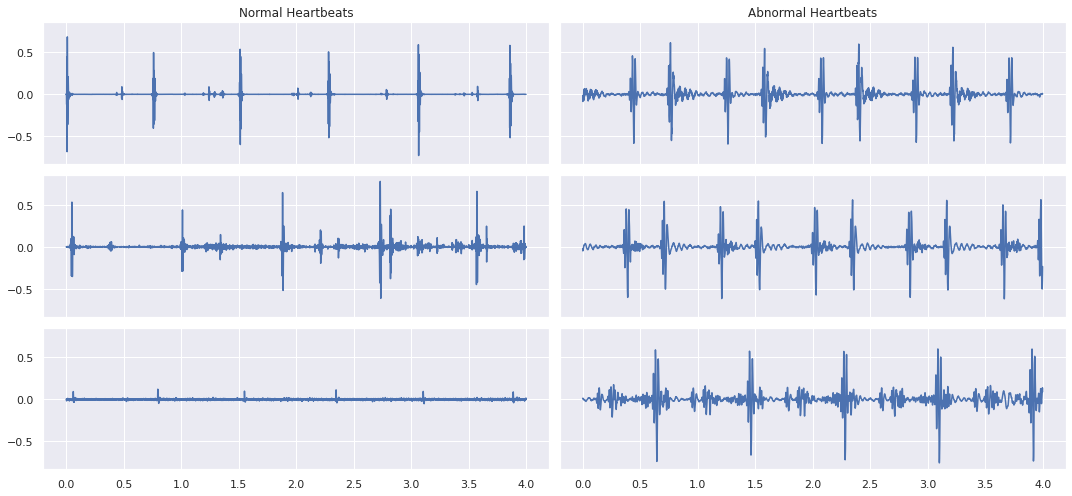

In [ ]:
def show_plot_and_make_titles():
   axs[0, 0].set(title="Normal Heartbeats")
   axs[0, 1].set(title="Abnormal Heartbeats")
   plt.tight_layout()
   plt.show()

sfreq = 2205

df = pd.read_hdf('audio_munged.hdf5', key='/h5io/key_data')
normal = df.loc[:, [3, 4, 6]]
abnormal = df.loc[:, [0, 1, 2]]

fig, axs = plt.subplots(3, 2, figsize=(15, 7), sharex=True, sharey=True)

# Calculate the time array
time = np.arange(len(normal)) / sfreq

# Stack the normal/abnormal audio so you can loop and plot
stacked_audio = np.hstack([normal, abnormal]).T

# Loop through each audio file / ax object and plot
# .T.ravel() transposes the array, then unravels it into a 1-D vector for looping
for iaudio, ax in zip(stacked_audio, axs.T.ravel()):
    ax.plot(time, iaudio)
show_plot_and_make_titles()

### ***Invariance in time***

While you should always start by visualizing your raw data, this is often uninformative when it comes to discriminating between two classes of data points. Data is usually noisy or exhibits complex patterns that aren't discoverable by the naked eye.

Another common technique to find simple differences between two sets of data is to average across multiple instances of the same class. This may remove noise and reveal underlying patterns (or, it may not).

In this exercise, you'll average across many instances of each class of heartbeat sound.

The two DataFrames (`normal` and `abnormal`) and the time array (`time`) from the previous exercise are available in your workspace.

* Average across the audio files contained in `normal` and `abnormal`, leaving the time dimension.

* Visualize these averages over time.

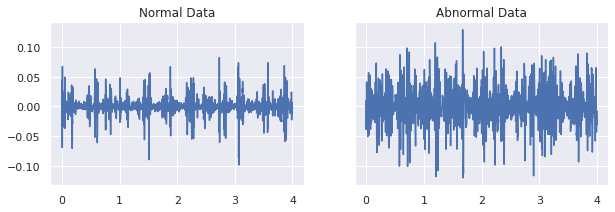

In [ ]:
df = pd.read_hdf('audio_munged.hdf5', key='/h5io/key_data')
normal = df.loc[:, [3, 4, 6, 7, 10, 12, 15, 16, 17, 18]]
abnormal = df.loc[:, [0, 1, 2, 5, 8, 9, 11, 13, 14, 19]]

# Average across the audio files of each DataFrame
mean_normal = np.mean(normal, axis=1)
mean_abnormal = np.mean(abnormal, axis=1)

# Plot each average over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ax1.plot(time, mean_normal)
ax1.set(title="Normal Data")
ax2.plot(time, mean_abnormal)
ax2.set(title="Abnormal Data")
plt.show()

Do you see a noticeable difference between the two? Maybe, but it's quite noisy. Let's see how you can dig into the data a bit further.

### ***Build a classification model*** 

While eye-balling differences is a useful way to gain an intuition for the data, let's see if you can operationalize things with a model. In this exercise, you will use each repetition as a datapoint, and each moment in time as a feature to fit a classifier that attempts to predict `abnormal` vs. `normal` heartbeats using only the raw data.

We've split the two DataFrames (`normal` and `abnormal`) into `X_train`, `X_test`, `y_train`, and `y_test`.

### ***I have no idea which column is used as y***

* Create an instance of the Linear SVC model and fit the model using the training data.

* Use the testing data to generate predictions with the model.
* Score the model using the provided code.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

df = pd.read_hdf('audio_munged.hdf5', key='/h5io/key_data')
X = df.T
y = np.array([['normal'], ['normal'], ['normal'], ['normal'], ['normal'], ['normal'], ['normal'], ['normal'], ['normal'], ['normal'], ['normal'], ['normal'], ['normal'], ['normal'], ['normal'], ['normal'], ['normal'], ['normal'],['normal'], ['normal'], ['normal'], ['normal'], ['normal'],  ['normal'], ['normal'], ['normal'], ['normal'], ['normal'], ['normal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal'],       ['abnormal']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


# Initialize and fit the model
model = LinearSVC()
model.fit(X_train, y_train)

# Generate predictions and score them manually
predictions = model.predict(X_test)
print(sum(predictions == y_test.squeeze()) / len(y_test))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


0.3888888888888889


Note that your predictions didn't do so well. That's because the features you're using as inputs to the model (raw data) aren't very good at differentiating classes. Next, you'll explore how to calculate some more complex features that may improve the results.

### ***Calculating the envelope of sound***

One of the ways you can improve the features available to your model is to remove some of the noise present in the data. In audio data, a common way to do this is to smooth the data and then rectify it so that the total amount of sound energy over time is more distinguishable. You'll do this in the current exercise.

A heartbeat file is available in the variable `audio`.

* Visualize the raw audio you'll use to calculate the envelope.

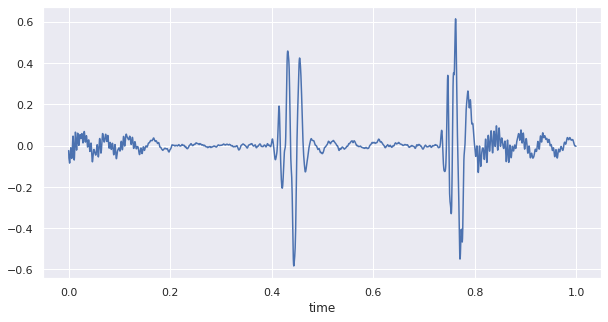

In [ ]:
df = pd.read_hdf('audio_munged.hdf5', key='/h5io/key_data')
audio = df.iloc[:2205,0]

# Plot the raw data first
audio.plot(figsize=(10, 5))
plt.show()

* Rectify the audio.
* Plot the result.

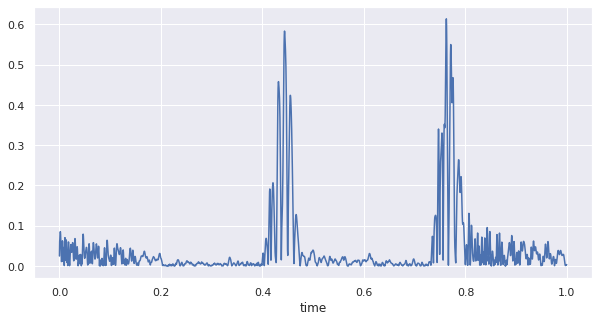

In [ ]:
# Rectify the audio signal
audio_rectified = audio.apply(np.abs)

# Plot the result
audio_rectified.plot(figsize=(10, 5))
plt.show()

* Smooth the audio file by applying a rolling mean.
Plot the result.

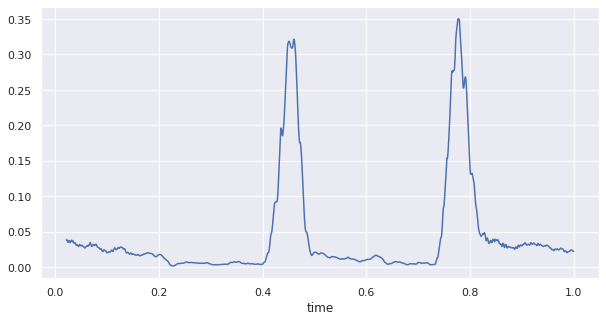

In [ ]:
# Smooth by applying a rolling mean
audio_rectified_smooth = audio_rectified.rolling(window=50).mean()

# Plot the result
audio_rectified_smooth.plot(figsize=(10, 5))
plt.show()

By calculating the envelope of each sound and smoothing it, you've eliminated much of the noise and have a cleaner signal to tell you when a heartbeat is happening.

### ***Calculating features from the envelope***

Now that you've removed some of the noisier fluctuations in the audio, let's see if this improves your ability to classify.

`audio_rectified_smooth` from the previous exercise is available in your workspace.

* Calculate the mean, standard deviation, and maximum value for each heartbeat sound.

* Column stack these stats in the same order.

* Use cross-validation to fit a model on each CV iteration.

In [ ]:
audio = pd.read_hdf('audio_munged.hdf5', key='/h5io/key_data')
audio_rectified = audio.apply(np.abs)
audio_rectified_smooth = audio_rectified.rolling(window=50).mean()
audio_rectified_smooth
labels = np.array(['murmur', 'murmur', 'murmur', 'normal', 'normal', 'murmur',        'normal', 'normal', 'murmur', 'murmur', 'normal', 'murmur',       'normal', 'murmur', 'murmur', 'normal', 'normal', 'normal',       'normal', 'murmur', 'normal', 'normal', 'murmur', 'murmur',       'normal', 'normal', 'normal', 'normal', 'murmur', 'murmur',       'murmur', 'normal', 'normal', 'normal', 'normal', 'murmur',       'murmur', 'murmur', 'normal', 'normal', 'normal', 'murmur',       'murmur', 'normal', 'murmur', 'murmur', 'murmur', 'murmur',       'normal', 'normal', 'murmur', 'normal', 'normal', 'murmur',       'murmur', 'normal', 'murmur', 'murmur', 'murmur', 'murmur'])

# Calculate stats
means = np.mean(audio_rectified_smooth, axis=0)
stds = np.std(audio_rectified_smooth, axis=0)
maxs = np.max(audio_rectified_smooth, axis=0)

# Create the X and y arrays
X = np.column_stack([means, stds, maxs])
y = labels.reshape([-1, 1])

# Fit the model and score on testing data
from sklearn.model_selection import cross_val_score

percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score))

0.7166666666666667


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

This model is both simpler (only 3 features) and more understandable (features are simple summary statistics of the data).

### ***Derivative features: The tempogram***

One benefit of cleaning up your data is that it lets you compute more sophisticated features. For example, the envelope calculation you performed is a common technique in computing tempo and rhythm features. In this exercise, you'll use **`librosa`** to compute some tempo and rhythm features for heartbeat data, and fit a model once more.

Note that **`librosa`** functions tend to only operate on **`numpy`** arrays instead of DataFrames, so we'll access our Pandas data as a Numpy array with the **`.values `**attribute.

* Use **`librosa`** to calculate a tempogram of each heartbeat audio.

* Calculate the mean, standard deviation, and maximum of each tempogram (this time using DataFrame methods)

In [ ]:
# Calculate the tempo of the sounds
tempos = []
for col, i_audio in audio.items():
    tempos.append(lr.beat.tempo(i_audio.values, sr=sfreq, hop_length=2**6, aggregate=None))

# Convert the list to an array so you can manipulate it more easily
tempos = np.array(tempos)

# Calculate statistics of each tempo
tempos_mean = tempos.mean(axis=-1)
tempos_std = tempos.std(axis=-1)
tempos_max = tempos.max(axis=-1)

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


* Column stack these tempo features (mean, standard deviation, and maximum) in the same order.

* Score the classifier with cross-validation.

In [ ]:
# Create the X and y arrays
X = np.column_stack([means, stds, maxs, tempos_mean, tempos_std, tempos_max])
y = labels.reshape([-1, 1])

# Fit the model and score on testing data
percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score))

0.55


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1

Note that your predictive power may not have gone up (because this dataset is quite small), but you now have a more rich feature representation of audio that your model can use!

### ***Spectrograms of heartbeat audio***

Spectral engineering is one of the most common techniques in machine learning for time series data. The first step in this process is to calculate a spectrogram of sound. This describes what spectral content (e.g., low and high pitches) are present in the sound over time. In this exercise, you'll calculate a spectrogram of a heartbeat audio file.

We've loaded a single heartbeat sound in the variable `audio`.


* Import the short-time fourier transform (**`stft`**) function from **`librosa.core`**.

* Calculate the spectral content (using the short-time fourier transform function) of `audio`.

* Convert the spectogram (`spec`) to decibels.

* Visualize the spectogram.

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


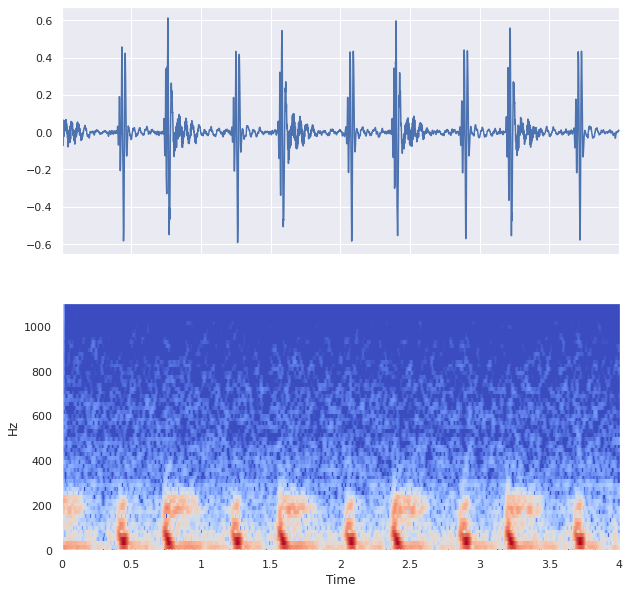

In [ ]:
from librosa.core import stft, amplitude_to_db
from librosa.display import specshow

audio = df.iloc[:, 0].values

# Prepare the STFT
HOP_LENGTH = 2**4
spec = stft(audio, hop_length=HOP_LENGTH, n_fft=2**7)

from librosa.core import amplitude_to_db
from librosa.display import specshow

# Convert into decibels
spec_db = amplitude_to_db(spec)

# Compare the raw audio to the spectrogram of the audio
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
axs[0].plot(time, audio)
specshow(spec_db, sr=sfreq, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH)
plt.show()

Do you notice that the heartbeats come in pairs, as seen by the vertical lines in the spectrogram?

### ***Engineering spectral features***

As you can probably tell, there is a lot more information in a spectrogram compared to a raw audio file. By computing the spectral features, you have a much better idea of what's going on. As such, there are all kinds of spectral features that you can compute using the spectrogram as a base. In this exercise, you'll look at a few of these features.

The spectogram `spec` from the previous exercise is available in your workspace.

* Calculate the **spectral bandwidth** as well as the **spectral centroid** of the spectrogram by using functions in **`librosa.feature`**.

In [ ]:
import librosa as lr

# Calculate the spectral centroid and bandwidth for the spectrogram
spec = np.abs(spec) # ไม่รู้ทำไม ต้องเปลี่ยนมาเป็นค่าบวก
bandwidths = lr.feature.spectral_bandwidth(S=spec)[0]
centroids = lr.feature.spectral_centroid(S=spec)[0]

* Convert the spectrogram to decibels for visualization.
* Plot the spectrogram over time.


AttributeError: ignored

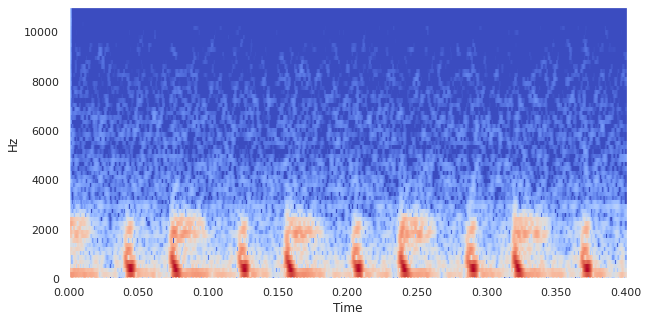

In [ ]:
from librosa.core import amplitude_to_db
from librosa.display import specshow

# Convert spectrogram to decibels for visualization
spec_db = amplitude_to_db(spec)

# Display these features on top of the spectrogram
fig, ax = plt.subplots(figsize=(10, 5))
ax = specshow(spec_db, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH)
ax.plot(times_spec, centroids)
ax.fill_between(times_spec, centroids - bandwidths / 2, centroids + bandwidths / 2, alpha=.5)
ax.set(ylim=[None, 6000])
plt.show()

### รูปไม่เหมือน มี error

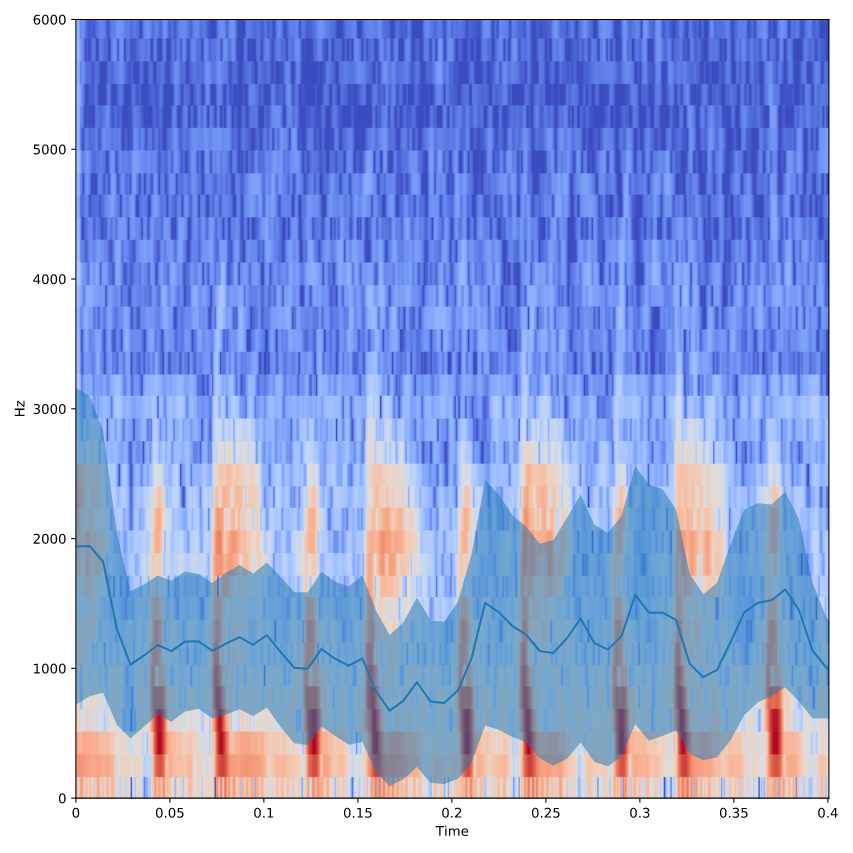


As you can see, the spectral centroid and bandwidth characterize the spectral content in each sound over time. They give us a summary of the spectral content that we can use in a classifier.



### ***Combining many features in a classifier***

You've spent this lesson engineering many features from the audio data - some contain information about how the audio changes in time, others contain information about the spectral content that is present.

The beauty of machine learning is that it can handle all of these features at the same time. If there is different information present in each feature, it should improve the classifier's ability to distinguish the types of audio. Note that this often requires more advanced techniques such as regularization, which we'll cover in the next chapter.

For the final exercise in the chapter, we've loaded many of the features that you calculated before. Combine all of them into an array that can be fed into the classifier, and see how it does.

* Loop through each spectrogram, calculating the mean spectral bandwidth and centroid of each.
* Column stack all the features to create the array `X`.
* Score the classifier with cross-validation.

In [ ]:
audio = df.values
HOP_LENGTH = 2**4
spectrograms = []
for i in range(audio.shape[1]):
    spec = stft(audio[:, i], hop_length=HOP_LENGTH, n_fft=2**7)
    spectrograms.append(np.abs(spec)) # ต้องมี np.abs 

from librosa.core import amplitude_to_db
from librosa.display import specshow

# Convert into decibels
spec_db = amplitude_to_db(spec)


# Loop through each spectrogram
bandwidths = []
centroids = []

for spec in spectrograms:
    # Calculate the mean spectral bandwidth
    this_mean_bandwidth = np.mean(lr.feature.spectral_bandwidth(S=spec))
    # Calculate the mean spectral centroid
    this_mean_centroid = np.mean(lr.feature.spectral_centroid(S=spec))
    # Collect the values
    bandwidths.append(this_mean_bandwidth)  
    centroids.append(this_mean_centroid)

# Create X and y arrays
X = np.column_stack([means, stds, maxs, tempos_mean, tempos_max, tempos_std, bandwidths, centroids])
y = labels.reshape([-1, 1])

# Fit the model and score on testing data
percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score))

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


0.5666666666666667


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1

You calculated many different features of the audio, and combined each of them under the assumption that they provide independent information that can be used in classification. You may have noticed that the accuracy of your models varied a lot when using different set of features. This chapter was focused on creating new "features" from raw data and not obtaining the best accuracy. To improve the accuracy, you want to find the right features that provide relevant information and also build models on much larger data.

### ***Introducing the dataset***

As mentioned in the video, you'll deal with stock market prices that fluctuate over time. In this exercise you've got historical prices from two tech companies (Ebay and Yahoo) in the DataFrame `prices`. You'll visualize the raw data for the two companies, then generate a scatter plot showing how the values for each company compare with one another. Finally, you'll add in a "time" dimension to your scatter plot so you can see how this relationship changes over time.


1.  Plot the data in `prices`. Pay attention to any irregularities you notice.


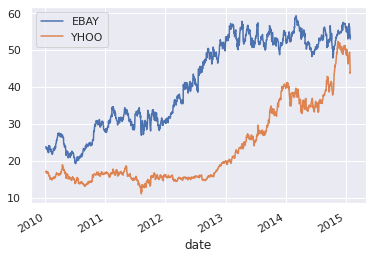

In [ ]:
# Read in the data
data = pd.read_csv('prices.csv', index_col=0).drop(columns='volume')
data.index = pd.to_datetime(data.index)
sublist = ['EBAY',  'YHOO']
data = data.query("symbol == @sublist")
g = data.groupby('symbol')
temp = []
EBAY, YHOO = g.get_group('EBAY'), g.get_group('YHOO')
for i, j in zip([EBAY, YHOO], sublist):
    i = i.rename(columns={'close': j})
    i.drop(columns='symbol', inplace=True)
    temp.append(i)
prices = pd.concat(temp, axis=1).loc[:'2015-01-30']    

# Plot the raw values over time
prices.plot()
plt.show()


2.  Generate a scatter plot with the values of Ebay on the x-axis, and Yahoo on the y-axis. Look up the symbols for both companies from the column names of the DataFrame.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


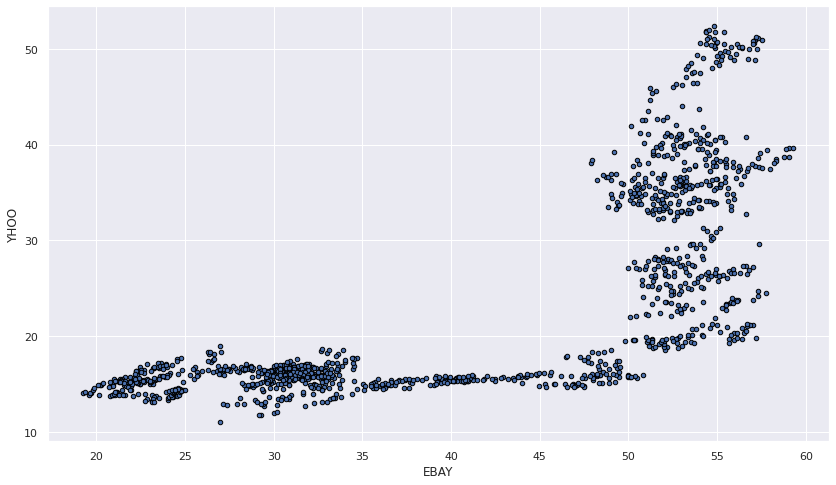

In [ ]:
# Scatterplot with one company per axis
prices.plot.scatter('EBAY', 'YHOO', figsize=(14, 8), edgecolor='black')
plt.show()

3. Finally, encode time as the color of each datapoint in order to visualize how the relationship between these two variables changes.

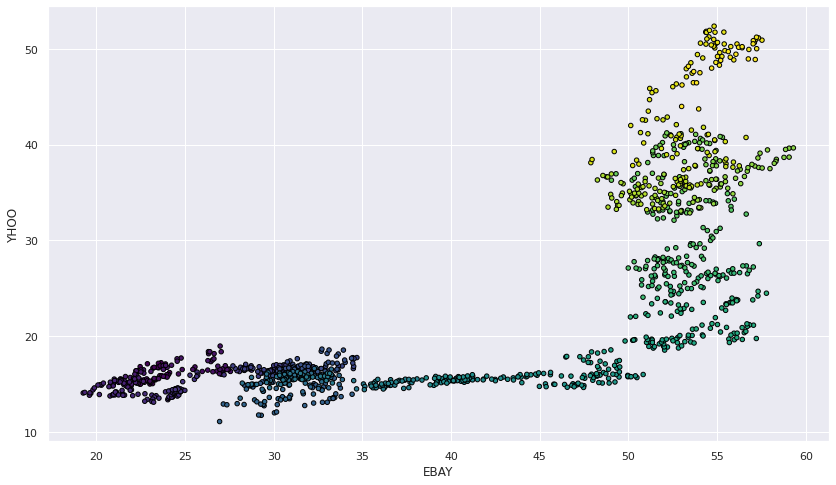

In [ ]:
# Scatterplot with color relating to time
prices.plot.scatter('EBAY', 'YHOO', c=prices.index, cmap=plt.cm.viridis, colorbar=False, figsize=(14, 8), edgecolor='black')
plt.show()

These two time series seem somewhat related to each other, though its a complex relationship that changes over time.

### ***Fitting a simple regression model***

Now we'll look at a larger number of companies. Recall that we have historical price values for many companies. Let's use data from several companies to predict the value of a test company. You'll attempt to predict the value of the Apple stock price using the values of NVidia, Ebay, and Yahoo. Each of these is stored as a column in the `all_prices` DataFrame. Below is a mapping from company name to column name:

```
ebay: "EBAY"
nvidia: "NVDA"
yahoo: "YHOO"
apple: "AAPL"
```

We'll use these columns to define the input/output arrays in our model.

* Create the `X` and `y` arrays by using the column names provided.
* The input values should be from the companies "ebay", "nvidia", and "yahoo"
* The output values should be from the company "apple"
* Use the data to train and score the model with cross-validation.

In [ ]:
data = pd.read_csv('prices.csv', index_col=0).drop(columns='volume')
data.index = pd.to_datetime(data.index)
symbols = set(data['symbol'])
g = data.groupby('symbol')
temp = []
stocks = [] 
for i in symbols:
    stocks.append(g.get_group(i))

for i, j in zip(stocks, symbols):
    i = i.rename(columns={'close': j})
    i.drop(columns='symbol', inplace=True)
    temp.append(i)
all_prices = pd.concat(temp, axis=1).loc[:'2015-01-30'] 
all_prices = all_prices.reindex(sorted(all_prices.columns), axis=1)

##############################################################################

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Use stock symbols to extract training data
X = all_prices[["EBAY", "NVDA", "YHOO"]]
y = all_prices[["AAPL"]]

# Fit and score the model with cross-validation
scores = cross_val_score(Ridge(), X, y, cv=3)
print(scores)

[-6.09050633 -0.3179172  -3.72957284]


Fitting a model with raw data doesn't give great results.

### ***Visualizing predicted values***

When dealing with time series data, it's useful to visualize model predictions on top of the "actual" values that are used to test the model.

In this exercise, after splitting the data (stored in the variables `X` and `y`) into training and test sets, you'll build a model and then visualize the model's predictions on top of the testing data in order to estimate the model's performance.

* Split the data (`X` and `y`) into training and test sets.
* Use the training data to train the regression model.
* Then use the testing data to generate predictions for the model.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = X.iloc[:775].values
y = y.iloc[:775].values

# Split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8,shuffle=False, random_state=1)

# Fit our model and generate predictions
model = Ridge()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = r2_score(y_test, predictions)
print(score)

-5.709399019485158


* Plot a time series of the predicted and "actual" values of the testing data.

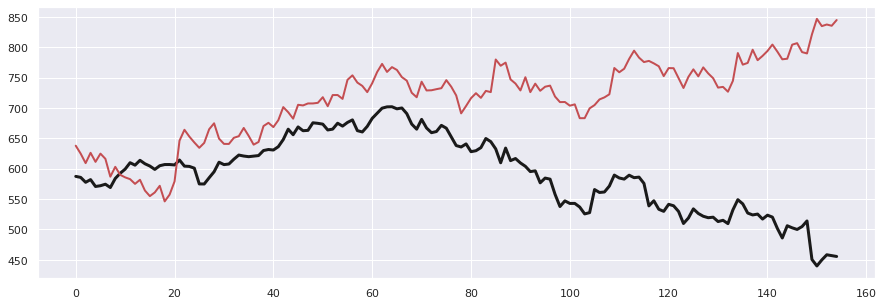

In [ ]:
# Visualize our predictions along with the "true" values, and print the score
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test, color='k', lw=3)
ax.plot(predictions, color='r', lw=2)
plt.show()

Now you have an explanation for your poor score. The predictions clearly deviate from the true time series values.

# ***Interpolation in Pandas***


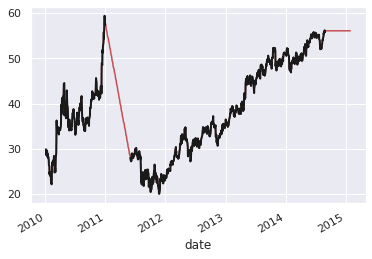

In [ ]:
prices = all_prices['AIG'].copy()
prices.loc['2011-01-01': '2011-06-01'], prices.loc['2014-09-01': ] = np.nan, np.nan

# Return a boolean that notes where missing values are
missing = prices.isna()

# Interpolate linearly within missing windows
prices_interp = prices.interpolate('linear')

# Plot the interpolated data in red and the data w/ missing values in black
ax = prices_interp.plot(c='r')
prices.plot(c='k', ax=ax, lw=2)
plt.show()

# ***Transforming to percent change with Pandas***

In [ ]:
def percent_change(values): # % change for the final value
    """Calculates the % change between the last value and the mean of previous values"""
    
    # Separate the last value and all previous values into variables
    previous_values = values[:-1]
    last_value = values[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

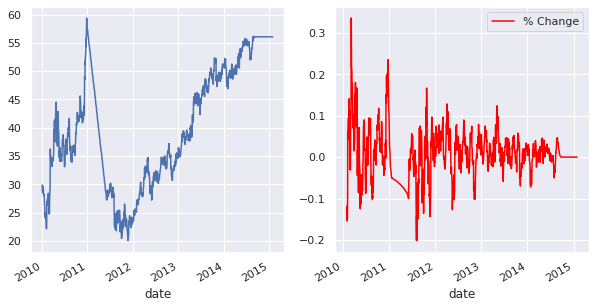

In [ ]:
prices = prices_interp

# Plot the raw data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = prices.plot(ax=axs[0])

# Calculate % change and plot
ax = prices.rolling(window=20).aggregate(percent_change).plot(ax=axs[1], label='% Change', color='red')
ax.legend()
plt.show()

# ***Finding outliers by plotting threshold***

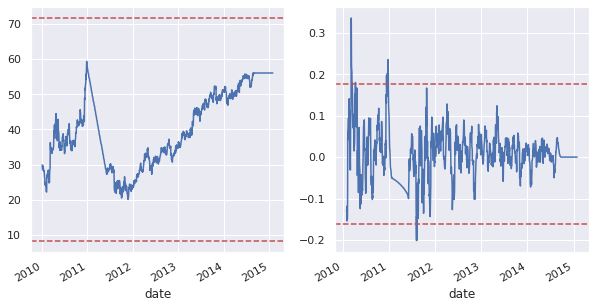

In [ ]:
prices_perc_change = prices.rolling(window=20).aggregate(percent_change)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for data, ax in zip([prices, prices_perc_change], axs):
    # Calculate the mean / standard deviation for the data
    this_mean = data.mean()
    this_std = data.std()
    
    # Plot the data, with a window that is 3 standard deviations
    # around the mean
    data.plot(ax=ax)
    ax.axhline(this_mean + this_std * 3, ls='--', c='r')
    ax.axhline(this_mean - this_std * 3, ls='--', c='r')  

plt.show()

# ***Replacing outliers using the threshold***

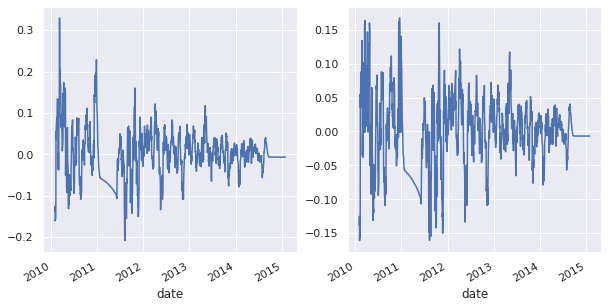

In [ ]:
prices_outlier_perc = prices_perc_change

# Center the data so the mean is 0
prices_outlier_centered = prices_outlier_perc - prices_outlier_perc.mean()

# Calculate standard deviation
std = prices_outlier_perc.std()

# Use the absolute value of each datapoint
# to make it easier to find outliers
outliers = np.abs(prices_outlier_centered) > (std * 3)

# Replace outliers with the median value
# We'll use np.nanmean since there may be nans around the outliers
prices_outlier_fixed = prices_outlier_centered.copy()
prices_outlier_fixed[outliers] = np.nanmedian(prices_outlier_fixed)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
prices_outlier_centered.plot(ax=axs[0])
prices_outlier_fixed.plot(ax=axs[1])
plt.show()

### ***Visualizing messy data***

Let's take a look at a new dataset - this one is a bit less-clean than what you've seen before.

As always, you'll first start by visualizing the raw data. Take a close look and try to find datapoints that could be problematic for fitting models.

The data has been loaded into a DataFrame called `prices`.

* Visualize the time series data using Pandas.

* Calculate the number of missing values in each time series. Note any irregularities that you can see. What do you think they are?

In [ ]:
prices = all_prices[['EBAY',        'NVDA',       'YHOO']]

# Visualize the dataset
prices.plot(legend=False)
plt.tight_layout()
plt.show()

# Count the missing values of each time series
missing_values = prices.isna().sum()
print(missing_values)


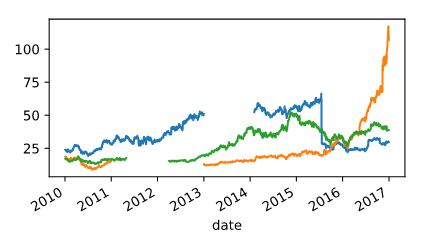

In the plot, you can see there are clearly missing chunks of time in your data. There also seem to be a few 'jumps' in the data. How can you deal with this?

### ***Imputing missing values***
When you have missing data points, how can you fill them in?

In this exercise, you'll practice using different interpolation methods to fill in some missing values, visualizing the result each time. But first, you will create the function (`interpolate_and_plot()`) you'll use to interpolate missing data points and plot them.

A single time series has been loaded into a DataFrame called `prices`.

* Create a boolean mask for missing values and interpolate the missing values using the `interpolation` argument of the function.

In [ ]:
# Create a function we'll use to interpolate and plot
def interpolate_and_plot(prices, interpolation):

    # Create a boolean mask for missing values
    missing_values = prices.isna()

    # Interpolate the missing values
    prices_interp = prices.interpolate(interpolation)

    # Plot the results, highlighting the interpolated values in black
    fig, ax = plt.subplots(figsize=(10, 5))
    prices_interp.plot(color='k', alpha=.6, ax=ax, legend=False)
    
    # Now plot the interpolated values on top in red
    prices_interp[missing_values].plot(ax=ax, color='r', lw=3, legend=False)
    plt.show()

* Interpolate using the latest non-missing value and plot the results. Recall that `interpolate_and_plot`'s second input is a string specifying the kind of interpolation to use.

In [ ]:
# Interpolate using the latest non-missing value
interpolation_type = 'zero'
interpolate_and_plot(prices, interpolation_type)

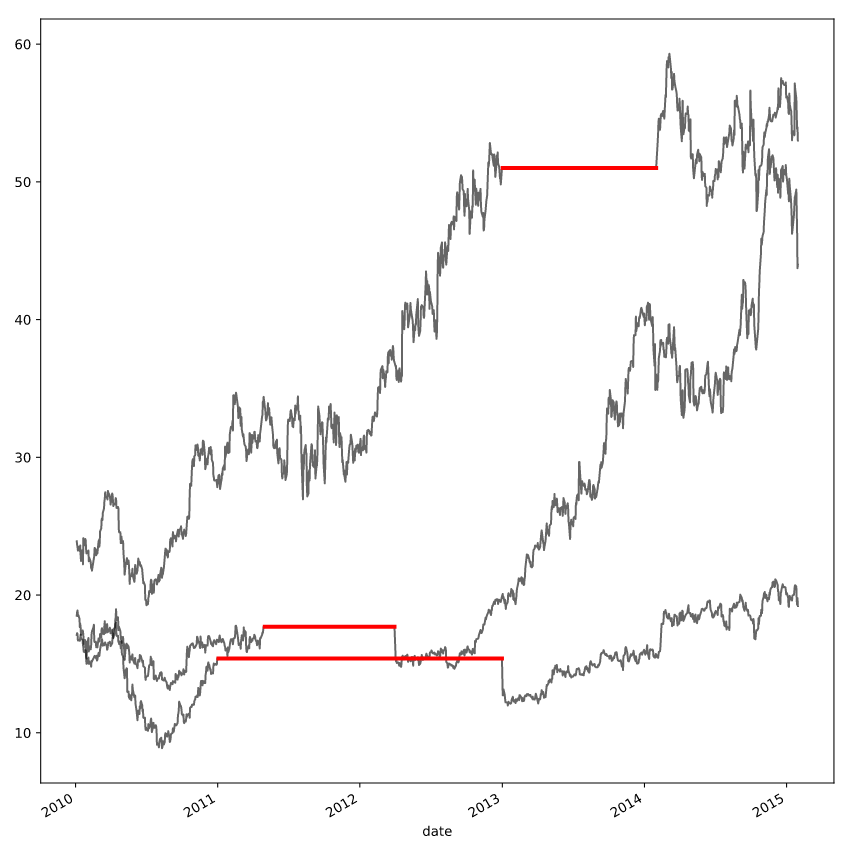

* Interpolate linearly and plot the results.

In [ ]:
# Interpolate linearly
interpolation_type = 'linear'
interpolate_and_plot(prices, interpolation_type)

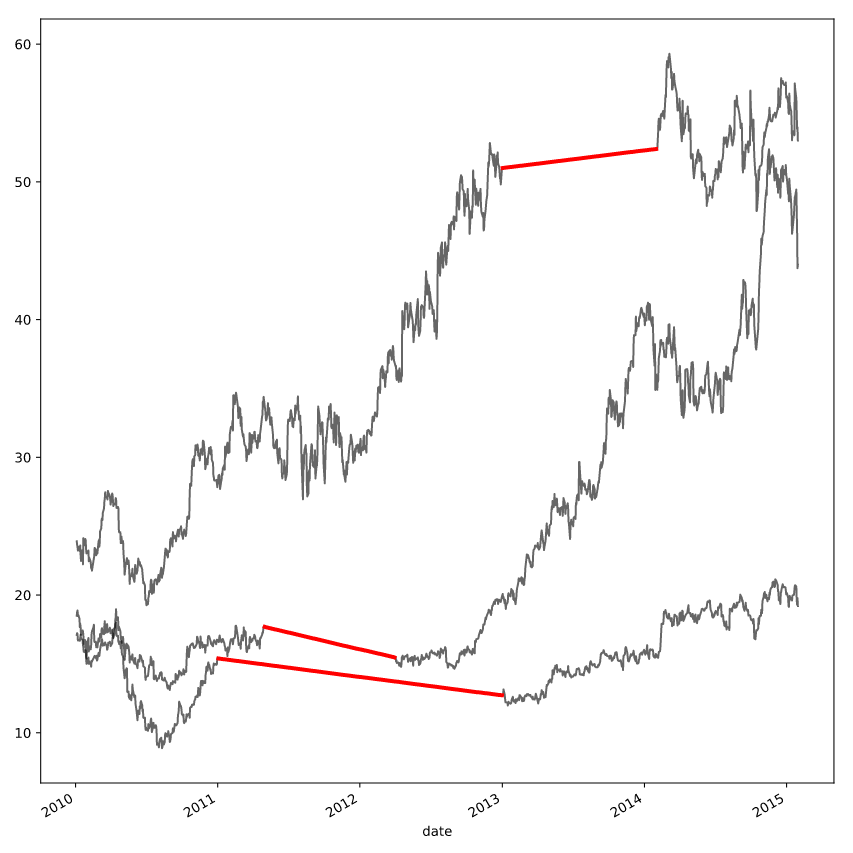

* Interpolate with a quadratic function and plot the results.

In [ ]:
# Interpolate with a quadratic function
interpolation_type = 'quadratic'
interpolate_and_plot(prices, interpolation_type)

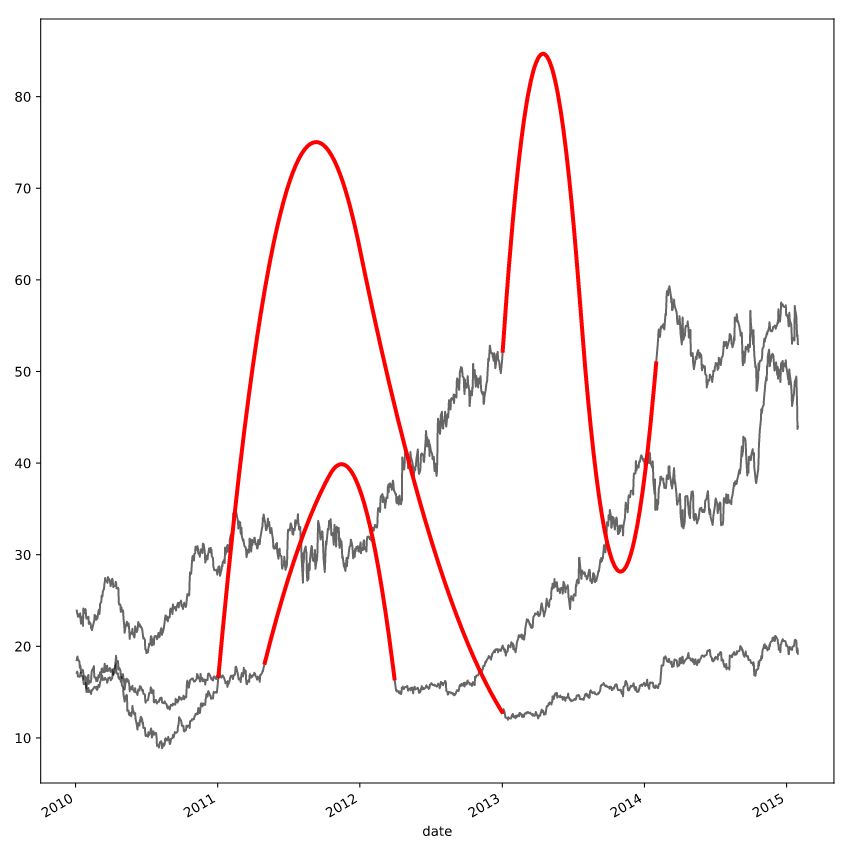

### ***Transforming raw data***

In the last chapter, you calculated the rolling mean. In this exercise, you will define a function that calculates the percent change of the latest data point from the mean of a window of previous data points. This function will help you calculate the percent change over a rolling window.

This is a more stable kind of time series that is often useful in machine learning.

* Define a `percent_change` function that takes an input time series and does the following:
    * Extract all but the last value of the input series (assigned to `previous_values`) and the only the last value of the timeseries ( assigned to `last_value`)

    * Calculate the percentage difference between the last value and the mean of earlier values.

* Using a rolling window of 20, apply this function to `prices`, and visualize it using the given code.

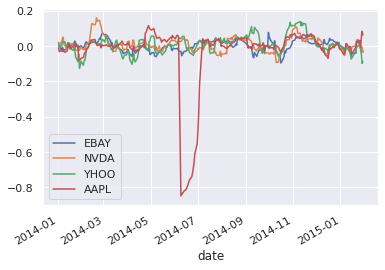

In [ ]:
prices = all_prices[['EBAY', 'NVDA', 'YHOO', 'AAPL']]

# Your custom function
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

# Apply your custom function and plot
prices_perc = prices.rolling(20).apply(percent_change)
prices_perc.loc["2014":"2015"].plot()
plt.show()

You've converted the data so it's easier to compare one time point to another. This is a cleaner representation of the data.

### ***Handling outliers***

In this exercise, you'll handle outliers - data points that are so different from the rest of your data, that you treat them differently from other "normal-looking" data points. You'll use the output from the previous exercise (percent change over time) to detect the outliers. First you will write a function that replaces outlier data points with the median value from the entire time series.

* Define a function that takes an input series and does the following:

  * Calculates the absolute value of each datapoint's distance from the series mean, then creates a boolean mask for datapoints that are three times the standard deviation from the mean.
  * Use this boolean mask to replace the outliers with the median of the entire series.

* Apply this function to your data and visualize the results using the given code.

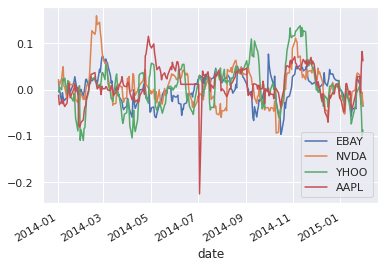

In [ ]:
def replace_outliers(series):
    # Calculate the absolute difference of each timepoint from the series mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))
    
    # Calculate a mask for the differences that are > 3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)
    
    # Replace these values with the median accross the data
    series[this_mask] = np.nanmedian(series)
    return series

# Apply your preprocessing function to the timeseries and plot the results
prices_perc = prices_perc.apply(replace_outliers)
prices_perc.loc["2014":"2015"].plot()
plt.show()

Since you've converted the data to % change over time, it was easier to spot and correct the outliers.

# ***Using `.aggregate` for feature extraction***

In [ ]:
prices = all_prices[['AIG', 'ABT']]

# Visualize the raw data
print(prices.head(3))

                  AIG        ABT
date                            
2010-01-04  29.889999  54.459951
2010-01-05  29.330000  54.019953
2010-01-06  29.139999  54.319953


**`.aggregate`** can be used to compute many aggregations at once

In [ ]:
# Calculate a rolling window, then extract two features
feats = prices.rolling(20).aggregate([np.std, np.max]).dropna()
print(feats.head(3))

                 AIG                  ABT           
                 std       amax       std       amax
date                                                
2010-02-01  2.051966  29.889999  0.868830  56.239949
2010-02-02  2.101032  29.629999  0.869197  56.239949
2010-02-03  2.157249  29.629999  0.852509  56.239949


# ***Using `partial()` in Python***

In [ ]:
# If we just take the mean, it returns a single value
a = np.array([[0, 1, 2], [0, 1, 2], [0, 1, 2]])
print(np.mean(a))
print((0+1+2+0+1+2+0+1+2)/9)

1.0
1.0


In [ ]:
# We can use the partial function to initialize np.mean ฅwith an axis parameter

from functools import partial
mean_over_first_axis = partial(np.mean, axis=0)
print(mean_over_first_axis(a))

# ก็เหมือนกัน ?
print(np.mean(a, axis=0))

[0. 1. 2.]
[0. 1. 2.]


### ***Engineering multiple rolling features at once***

Now that you've practiced some simple feature engineering, let's move on to something more complex. You'll calculate a collection of features for your time series data and visualize what they look like over time. This process resembles how many other time series models operate.

* Define a list consisting of four features you will calculate: the minimum, maximum, mean, and standard deviation (in that order).

* Using the rolling window (`prices_perc_rolling`) we defined for you, calculate the features from `features_to_calculate`.

*  Plot the results over time, along with the original time series using the given code.

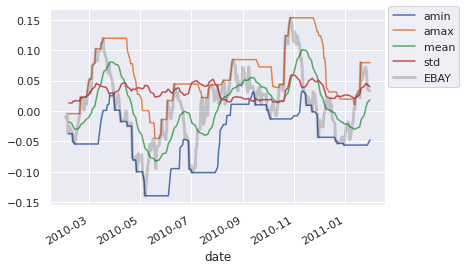

In [ ]:
prices = all_prices[['EBAY', 'NVDA', 'YHOO', 'AAPL']]
prices_perc = prices['EBAY'].rolling(20).apply(percent_change)

# Define a rolling window with Pandas, excluding the right-most datapoint of the window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')

# Define the features you'll calculate for each window
features_to_calculate = [np.min, np.max, np.mean, np.std]

# Calculate these features for your rolling window object
features = prices_perc_rolling.aggregate(features_to_calculate)

# Plot the results
ax = features.loc[:"2011-01"].plot()
prices_perc.loc[:"2011-01"].plot(ax=ax, color='k', alpha=.2, lw=3)
ax.legend(loc=(1.01, .6))
plt.show()


### ***Percentiles and partial functions***

In this exercise, you'll practice how to pre-choose arguments of a function so that you can pre-configure how it runs. You'll use this to calculate several percentiles of your data using the same **`percentile(`**) function in **`numpy`**.

* Import **`partial`** from **`functools`**.

* Use the **`partial()`** function to create several feature generators that calculate percentiles of your data using a list comprehension.

* Using the rolling window (`prices_perc_rolling`) we defined for you, calculate the quantiles using `percentile_functions`.

* Visualize the results using the code given to you.

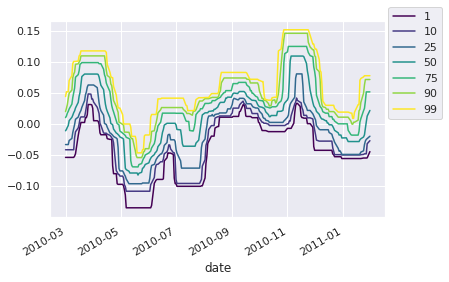

In [ ]:
# Import partial from functools
from functools import partial
percentiles = [1, 10, 25, 50, 75, 90, 99]

# Use a list comprehension to create a partial function for each quantile
percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]

# Calculate each of these quantiles on the data using a rolling window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')
features_percentiles = prices_perc_rolling.aggregate(percentile_functions)

# Plot a subset of the result
ax = features_percentiles.loc[:"2011-01"].plot(cmap=plt.cm.viridis)
ax.legend(percentiles, loc=(1.01, .5))
plt.show()

### ***Using "date" information***

It's easy to think of timestamps as pure numbers, but don't forget they generally correspond to things that happen in the real world. That means there's often extra information encoded in the data such as "is it a weekday?" or "is it a holiday?". This information is often useful in predicting timeseries data.

In this exercise, you'll extract these date/time based features. A single time series has been loaded in a variable called `prices`.

* Calculate the day of the week, week number in a year, and month number in a year.

* Add each one as a column to the `prices_perc` DataFrame, under the names `day_of_week`, `week_of_year` and `month_of_year`, respectively.

In [ ]:
prices = all_prices[['EBAY', 'NVDA', 'YHOO', 'AAPL']]
prices_perc = prices[['EBAY']].rolling(20).apply(percent_change).dropna()

prices_perc.index = pd.to_datetime(prices_perc.index)

# Extract date features from the data, add them as columns
prices_perc['day_of_week'] = prices_perc.index.weekday
prices_perc['week_of_year'] = prices_perc.index.week
prices_perc['month_of_year'] = prices_perc.index.month

# Print prices_perc
print(prices_perc)

                EBAY  day_of_week  week_of_year  month_of_year
date                                                          
2010-02-01 -0.009963            0             5              2
2010-02-02 -0.012187            1             5              2
2010-02-03 -0.004488            2             5              2
2010-02-04 -0.037329            3             5              2
2010-02-05 -0.024462            4             5              2
...              ...          ...           ...            ...
2015-01-26  0.011183            0             5              1
2015-01-27 -0.012609            1             5              1
2015-01-28 -0.025789            2             5              1
2015-01-29 -0.020465            3             5              1
2015-01-30 -0.035902            4             5              1

[1259 rows x 4 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

# ***Time-shifting data with Pandas***

In [ ]:
df = pd.Series(np.arange(0, 11)).astype(float)
df

0      0.0
1      1.0
2      2.0
3      3.0
4      4.0
5      5.0
6      6.0
7      7.0
8      8.0
9      9.0
10    10.0
dtype: float64

In [ ]:
df.shift(3)

0     NaN
1     NaN
2     NaN
3     0.0
4     1.0
5     2.0
6     3.0
7     4.0
8     5.0
9     6.0
10    7.0
dtype: float64

In [ ]:
df.shift(-3)

0      3.0
1      4.0
2      5.0
3      6.0
4      7.0
5      8.0
6      9.0
7     10.0
8      NaN
9      NaN
10     NaN
dtype: float64

# ***Time-shifted DataFrame***

In [ ]:
# Shifts
shifts = [0, 1, 2, 3, 4, 5, 6, 7]

# Create a dictionary of time-shifted data
many_shifts = {'lag_{}'.format(j): df.shift(j) for j in shifts}

# Convert them into a dataframe
many_shifts = pd.DataFrame(many_shifts)
many_shifts

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
3,3.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN
4,4.0,3.0,2.0,1.0,0.0,NaN,NaN,NaN
5,5.0,4.0,3.0,2.0,1.0,0.0,NaN,NaN
6,6.0,5.0,4.0,3.0,2.0,1.0,0.0,NaN
7,7.0,6.0,5.0,4.0,3.0,2.0,1.0,0.0
8,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0
9,9.0,8.0,7.0,6.0,5.0,4.0,3.0,2.0


# ***Fitting a model with time-shifted features***

In [ ]:
model = Ridge()
model.fit(many_shifts, data)

# ***Interpreting the auto-regressive model coefficients***



In [ ]:
# Visualize the fit model coefficients
fig, ax = plt.subplots()
ax.bar(many_shifts.columns, model.coef_)
ax.set(xlabel='Coefficient name', ylabel='Coefficient value')

# Set formatting so it looks nice
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

### ***Creating time-shifted features***

In machine learning for time series, it's common to use information about previous time points to predict a subsequent time point.

In this exercise, you'll "shift" your raw data and visualize the results. You'll use the percent change time series that you calculated in the previous chapter, this time with a very short window. A short window is important because, in a real-world scenario, you want to predict the day-to-day fluctuations of a time series, not its change over a longer window of time.

* Use a dictionary comprehension to create multiple time-shifted versions of `prices_perc` using the lags specified in `shifts`.

* Convert the result into a DataFrame.


In [ ]:
prices = all_prices['AAPL']
prices_perc = prices.rolling(20).apply(percent_change)
prices_perc

date
2010-01-04         NaN
2010-01-05         NaN
2010-01-06         NaN
2010-01-07         NaN
2010-01-08         NaN
                ...   
2015-01-26    0.028172
2015-01-27   -0.007405
2015-01-28    0.051109
2015-01-29    0.082385
2015-01-30    0.062209
Name: AAPL, Length: 1278, dtype: float64

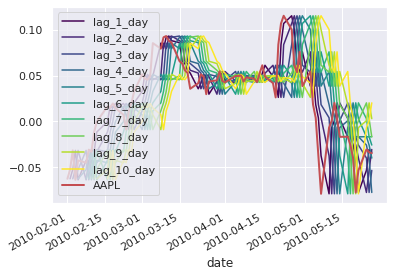

In [ ]:
# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
ax = prices_perc_shifted.iloc[:100].plot(cmap=plt.cm.viridis)
prices_perc.iloc[:100].plot(color='r', lw=2)
ax.legend(loc='best')
plt.show()

### ***Special case: Auto-regressive models***

Now that you've created time-shifted versions of a single time series, you can fit an auto-regressive model. This is a regression model where the input features are time-shifted versions of the output time series data. You are using previous values of a timeseries to predict current values of the same timeseries (thus, it is auto-regressive).

By investigating the coefficients of this model, you can explore any repetitive patterns that exist in a timeseries, and get an idea for how far in the past a data point is predictive of the future.

* Replace missing values in `prices_perc_shifted` with the median of the DataFrame and assign it to `X`.

* Replace missing values in `prices_perc` with the median of the series and assign it to `y`.

* Fit a regression model using the `X` and `y` arrays.

In [ ]:
prices_perc = all_prices['AAPL'].pct_change()
shifts = np.arange(1, 11).astype(int)
shifted_data = {"lag_{}_day".format(day_shift): prices_perc.shift(day_shift) for day_shift in shifts}
prices_perc_shifted = pd.DataFrame(shifted_data)

# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc.fillna(np.nanmedian(prices_perc))

# Fit the model
model = Ridge()
model.fit(X, y)

Ridge()

### ***Visualize regression coefficients***

Now that you've fit the model, let's visualize its coefficients. This is an important part of machine learning because it gives you an idea for how the different features of a model affect the outcome.

The shifted time series DataFrame (`prices_perc_shifted`) and the regression model (`model`) are available in your workspace.

In this exercise, you will create a function that, given a set of coefficients and feature names, visualizes the coefficient values.


* Define a function (called `visualize_coefficients`) that takes as input 
  * an array of coefficients, 
  * an array of each coefficient's name, and 
  * an instance of a Matplotlib axis object. 
  
* It should then generate a bar plot for the input coefficients, with their names on the x-axis.

In [ ]:
def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names, coefs)
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value')
    
    # Set formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    return ax

* Use this function (`visualize_coefficients()`) with the coefficients contained in the model variable and column names of `prices_perc_shifted`.

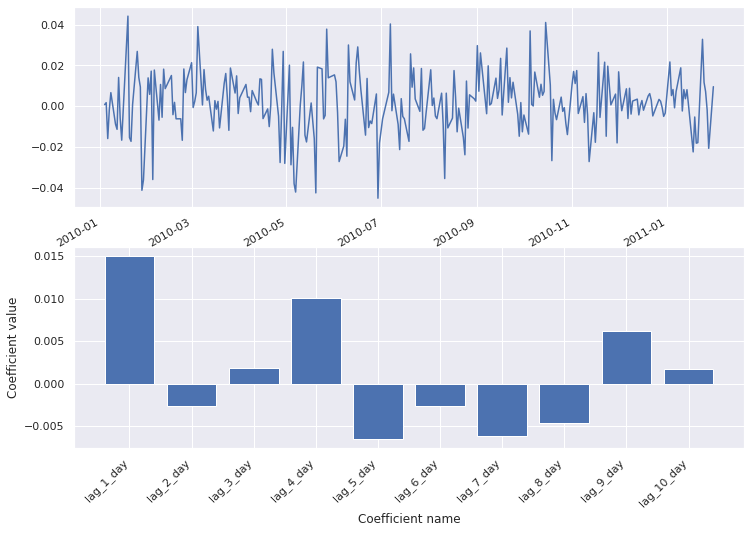

In [ ]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(12, 9))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

When you use time-lagged features on the raw data, you see that the highest coefficient by far is the first one. This means that the N-1th time point is useful in predicting the Nth timepoint, but no other points are useful.

## ***ข้อมูลมีผลต่อกราฟข้างบนมาก ถ้าข้อมูลตามที่โหลดจากเว็บ (ซึ่งมีจำนวนข้อมูลน้อยกว่า) จะได้รูปต่างกัน!!!***

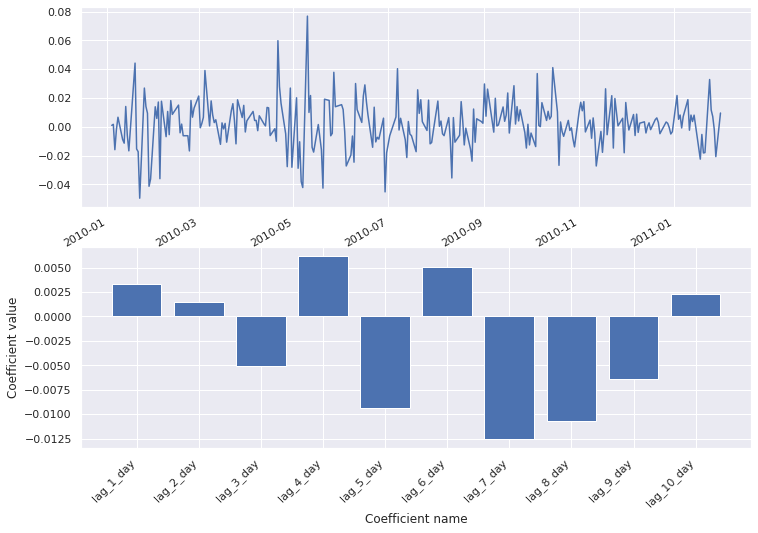

In [ ]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(12, 9))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

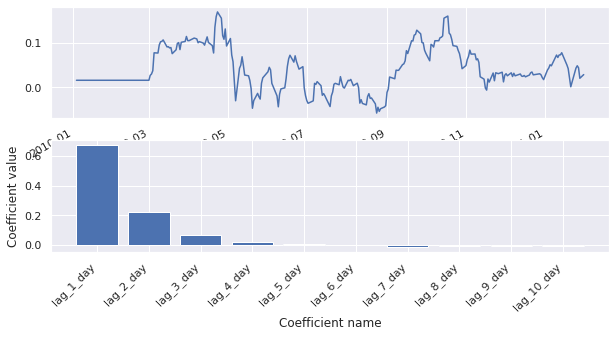

In [ ]:
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

prices = all_prices['AAPL']
prices_perc = prices.rolling(40).apply(percent_change)
shifts = np.arange(1, 11).astype(int)
shifted_data = {"lag_{}_day".format(day_shift): prices_perc.shift(day_shift) for day_shift in shifts}
prices_perc_shifted = pd.DataFrame(shifted_data)

# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc.fillna(np.nanmedian(prices_perc))

# Fit the model
model = Ridge()
model.fit(X, y)

# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

As you can see here, by transforming your data with a larger window, you've also changed the relationship between each timepoint and the ones that come just before it. This model's coefficients gradually go down to zero, which means that the signal itself is smoother over time. Be careful when you see something like this, as it means your data is not i.i.d.

# ***Cross validation***
# ***KFold***

* **`KFold`** cross-validation splits your data into multiple "folds" of equal size

In [ ]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5)

# Iterating over the "split" method yields train/test indices
for tr, tt in cv.split(X, y):
    model.fit(X[tr], y[tr])
    model.score(X[tt], y[tt])

# ***Visualizing model predictions***

In [ ]:
fig, axs = plt.subplots(2, 1)

# Plot the indices chosen for validation on each loop
axs[0].scatter(tt, [0] * len(tt), marker='_', s=2, lw=40)
axs[0].set(ylim=[-.1, .1], title='Test set indices (color=CV loop)', xlabel='Index of raw data')

# Plot the model predictions on each iteration
axs[1].plot(model.predict(X[tt]))
axs[1].set(title='Test set predictions on each CV loop', xlabel='Prediction index')

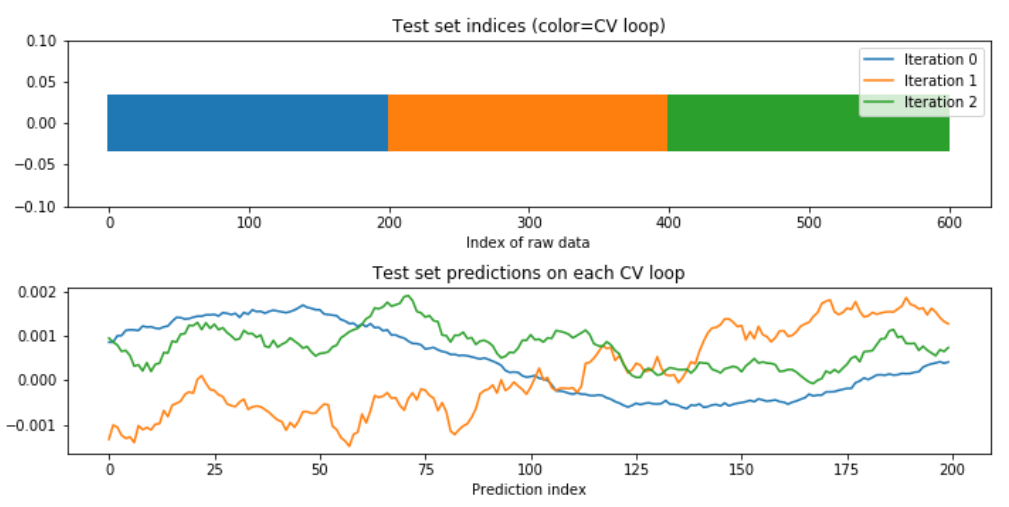

# ***Shuffled CV***

* Many CV iterators let you shuffle data as a part of the cross-validation process.
* This only works if the data is i.i.d., which timeseries usually is **not**.
* You should not shuffle your data when making predictions with timeseries.

In [ ]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=3)

for tr, tt in cv.split(X, y):
    model.fit(X[tr], y[tr])
    model.score(X[tt], y[tt])

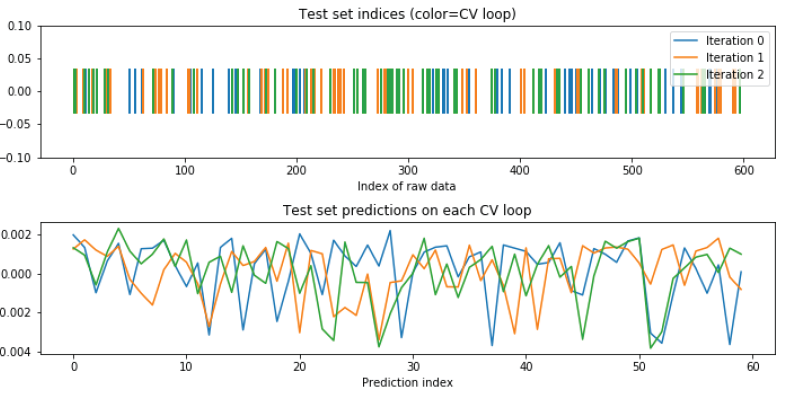

In [ ]:
# Import and initialize the cross-validation iterator
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=10)

fig, ax = plt.subplots(figsize=(10, 5))

for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Plot training and test indices
    l1 = ax.scatter(tr, [ii] * len(tr), c=[plt.cm.coolwarm(.1)], marker='_', lw=6)
    l2 = ax.scatter(tt, [ii] * len(tt), c=[plt.cm.coolwarm(.9)], marker='_', lw=6)
    ax.set(ylim=[10, -1], title='TimeSeriesSplit behavior', xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training', 'Validation'])

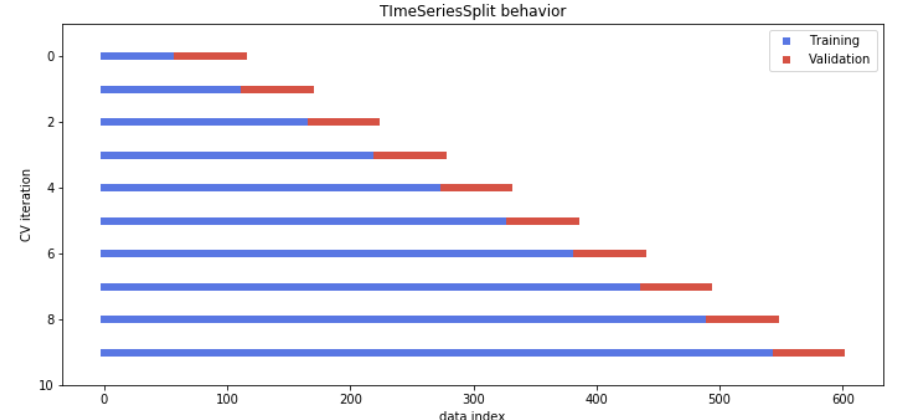

* ## จะใช้ข้อมูลที่มาก่อน พยากรณ์ข้อมูลที่มาหลังใน training set เสมอ

# ***Custom scoring functions in scikit-learn***

In [ ]:
def myfunction(estimator, X, y):
    y_pred = estimator.predict(X)
    my_custom_score = my_custom_function(y_pred, y)
    return my_custom_score

## ***ตัวอย่าง***

In [ ]:
def my_pearsonr(est, X, y):
    # Generate predictions and convert to a vector
    y_pred = est.predict(X).squeeze()
    
    # Use the numpy "corrcoef" function to calculate a correlation matrix
    my_corrcoef_matrix = np.corrcoef(y_pred, y.squeeze())
    
    # Return a single correlation value from the matrix
    my_corrcoef = my_corrcoef[1, 0]
    return my_corrcoef  

### ***Cross-validation with shuffling***

As you'll recall, cross-validation is the process of splitting your data into training and test sets multiple times. Each time you do this, you choose a different training and test set. In this exercise, you'll perform a traditional **`ShuffleSplit`** cross-validation on the company value data from earlier. Later we'll cover what changes need to be made for time series data. The data we'll use is the same historical price data for several large companies.

An instance of the Linear regression object (`model`) is available in your workspace along with the function `r2_score()` for scoring. Also, the data is stored in arrays `X` and `y`. We've also provided a helper function (`visualize_predictions()`) to help visualize the results.

* Initialize a **`ShuffleSplit`** cross-validation object with `10` splits.

* Iterate through CV splits using this object. On each iteration:
  * Fit a model using the training indices.
  * Generate predictions using the test indices, score the model ($R^2$) using the predictions, and collect the results.

In [6]:
from sklearn.metrics import r2_score

def visualize_predictions(results):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    # Loop through our model results to visualize them
    for ii, (prediction, score, indices) in enumerate(results):
        # Plot the predictions of the model in the order they were generated
        offset = len(prediction) * ii
        axs[0].scatter(np.arange(len(prediction)) + offset, prediction, label='Iteration {}'.format(ii))
        
        # Plot the predictions of the model according to how time was ordered
        axs[1].scatter(indices, prediction)
    axs[0].legend(loc="best")
    axs[0].set(xlabel="Test prediction number", title="Predictions ordered by test prediction number")
    axs[1].set(xlabel="Time", title="Predictions ordered by time")
    plt.show()

X = np.array([[ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [ 0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [-0.06251474,  0.00921183,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [-0.05244558, -0.06251474,  0.00921183,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [-0.03157502, -0.05244558, -0.06251474,  0.00921183,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [-0.06366353, -0.03157502, -0.05244558, -0.06251474,  0.00921183,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [-0.04248527, -0.06366353, -0.03157502, -0.05244558, -0.06251474,
         0.00921183,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [-0.04498189, -0.04248527, -0.06366353, -0.03157502, -0.05244558,
        -0.06251474,  0.00921183,  0.00921183,  0.00921183,  0.00921183],
       [-0.03078513, -0.04498189, -0.04248527, -0.06366353, -0.03157502,
        -0.05244558, -0.06251474,  0.00921183,  0.00921183,  0.00921183],
       [-0.03317265, -0.03078513, -0.04498189, -0.04248527, -0.06366353,
        -0.03157502, -0.05244558, -0.06251474,  0.00921183,  0.00921183],
       [-0.01157913, -0.03317265, -0.03078513, -0.04498189, -0.04248527,
        -0.06366353, -0.03157502, -0.05244558, -0.06251474,  0.00921183],
       [-0.00025475, -0.01157913, -0.03317265, -0.03078513, -0.04498189,
        -0.04248527, -0.06366353, -0.03157502, -0.05244558, -0.06251474],
       [ 0.01629393, -0.00025475, -0.01157913, -0.03317265, -0.03078513,
        -0.04498189, -0.04248527, -0.06366353, -0.03157502, -0.05244558],
       [ 0.01515433,  0.01629393, -0.00025475, -0.01157913, -0.03317265,
        -0.03078513, -0.04498189, -0.04248527, -0.06366353, -0.03157502],
       [ 0.01952763,  0.01515433,  0.01629393, -0.00025475, -0.01157913,
        -0.03317265, -0.03078513, -0.04498189, -0.04248527, -0.06366353],
       [ 0.01457628,  0.01952763,  0.01515433,  0.01629393, -0.00025475,
        -0.01157913, -0.03317265, -0.03078513, -0.04498189, -0.04248527],
       [ 0.00724221,  0.01457628,  0.01952763,  0.01515433,  0.01629393,
        -0.00025475, -0.01157913, -0.03317265, -0.03078513, -0.04498189],
       [-0.0089493 ,  0.00724221,  0.01457628,  0.01952763,  0.01515433,
         0.01629393, -0.00025475, -0.01157913, -0.03317265, -0.03078513],
       [ 0.01153336, -0.0089493 ,  0.00724221,  0.01457628,  0.01952763,
         0.01515433,  0.01629393, -0.00025475, -0.01157913, -0.03317265],
       [ 0.02024273,  0.01153336, -0.0089493 ,  0.00724221,  0.01457628,
         0.01952763,  0.01515433,  0.01629393, -0.00025475, -0.01157913],
       [ 0.03273157,  0.02024273,  0.01153336, -0.0089493 ,  0.00724221,
         0.01457628,  0.01952763,  0.01515433,  0.01629393, -0.00025475],
       [ 0.05127984,  0.03273157,  0.02024273,  0.01153336, -0.0089493 ,
         0.00724221,  0.01457628,  0.01952763,  0.01515433,  0.01629393],
       [ 0.04662419,  0.05127984,  0.03273157,  0.02024273,  0.01153336,
        -0.0089493 ,  0.00724221,  0.01457628,  0.01952763,  0.01515433],
       [ 0.04544773,  0.04662419,  0.05127984,  0.03273157,  0.02024273,
         0.01153336, -0.0089493 ,  0.00724221,  0.01457628,  0.01952763],
       [ 0.04955343,  0.04544773,  0.04662419,  0.05127984,  0.03273157,
         0.02024273,  0.01153336, -0.0089493 ,  0.00724221,  0.01457628],
       [ 0.08528803,  0.04955343,  0.04544773,  0.04662419,  0.05127984,
         0.03273157,  0.02024273,  0.01153336, -0.0089493 ,  0.00724221],
       [ 0.07931813,  0.08528803,  0.04955343,  0.04544773,  0.04662419,
         0.05127984,  0.03273157,  0.02024273,  0.01153336, -0.0089493 ],
       [ 0.09166373,  0.07931813,  0.08528803,  0.04955343,  0.04544773,
         0.04662419,  0.05127984,  0.03273157,  0.02024273,  0.01153336],
       [ 0.09301733,  0.09166373,  0.07931813,  0.08528803,  0.04955343,
         0.04544773,  0.04662419,  0.05127984,  0.03273157,  0.02024273],
       [ 0.08795296,  0.09301733,  0.09166373,  0.07931813,  0.08528803,
         0.04955343,  0.04544773,  0.04662419,  0.05127984,  0.03273157],
       [ 0.08586218,  0.08795296,  0.09301733,  0.09166373,  0.07931813,
         0.08528803,  0.04955343,  0.04544773,  0.04662419,  0.05127984],
       [ 0.06558961,  0.08586218,  0.08795296,  0.09301733,  0.09166373,
         0.07931813,  0.08528803,  0.04955343,  0.04544773,  0.04662419],
       [ 0.06304933,  0.06558961,  0.08586218,  0.08795296,  0.09301733,
         0.09166373,  0.07931813,  0.08528803,  0.04955343,  0.04544773],
       [ 0.05572306,  0.06304933,  0.06558961,  0.08586218,  0.08795296,
         0.09301733,  0.09166373,  0.07931813,  0.08528803,  0.04955343],
       [ 0.05268935,  0.05572306,  0.06304933,  0.06558961,  0.08586218,
         0.08795296,  0.09301733,  0.09166373,  0.07931813,  0.08528803],
       [ 0.03557406,  0.05268935,  0.05572306,  0.06304933,  0.06558961,
         0.08586218,  0.08795296,  0.09301733,  0.09166373,  0.07931813],
       [ 0.04164635,  0.03557406,  0.05268935,  0.05572306,  0.06304933,
         0.06558961,  0.08586218,  0.08795296,  0.09301733,  0.09166373],
       [ 0.05127673,  0.04164635,  0.03557406,  0.05268935,  0.05572306,
         0.06304933,  0.06558961,  0.08586218,  0.08795296,  0.09301733],
       [ 0.04888675,  0.05127673,  0.04164635,  0.03557406,  0.05268935,
         0.05572306,  0.06304933,  0.06558961,  0.08586218,  0.08795296],
       [ 0.02966561,  0.04888675,  0.05127673,  0.04164635,  0.03557406,
         0.05268935,  0.05572306,  0.06304933,  0.06558961,  0.08586218],
       [ 0.0434768 ,  0.02966561,  0.04888675,  0.05127673,  0.04164635,
         0.03557406,  0.05268935,  0.05572306,  0.06304933,  0.06558961],
       [ 0.04476574,  0.0434768 ,  0.02966561,  0.04888675,  0.05127673,
         0.04164635,  0.03557406,  0.05268935,  0.05572306,  0.06304933],
       [ 0.05444774,  0.04476574,  0.0434768 ,  0.02966561,  0.04888675,
         0.05127673,  0.04164635,  0.03557406,  0.05268935,  0.05572306],
       [ 0.04413187,  0.05444774,  0.04476574,  0.0434768 ,  0.02966561,
         0.04888675,  0.05127673,  0.04164635,  0.03557406,  0.05268935],
       [ 0.04251992,  0.04413187,  0.05444774,  0.04476574,  0.0434768 ,
         0.02966561,  0.04888675,  0.05127673,  0.04164635,  0.03557406],
       [ 0.04949983,  0.04251992,  0.04413187,  0.05444774,  0.04476574,
         0.0434768 ,  0.02966561,  0.04888675,  0.05127673,  0.04164635],
       [ 0.04940286,  0.04949983,  0.04251992,  0.04413187,  0.05444774,
         0.04476574,  0.0434768 ,  0.02966561,  0.04888675,  0.05127673],
       [ 0.05004689,  0.04940286,  0.04949983,  0.04251992,  0.04413187,
         0.05444774,  0.04476574,  0.0434768 ,  0.02966561,  0.04888675],
       [ 0.04343281,  0.05004689,  0.04940286,  0.04949983,  0.04251992,
         0.04413187,  0.05444774,  0.04476574,  0.0434768 ,  0.02966561],
       [ 0.04796825,  0.04343281,  0.05004689,  0.04940286,  0.04949983,
         0.04251992,  0.04413187,  0.05444774,  0.04476574,  0.0434768 ],
       [ 0.04650917,  0.04796825,  0.04343281,  0.05004689,  0.04940286,
         0.04949983,  0.04251992,  0.04413187,  0.05444774,  0.04476574],
       [ 0.0427404 ,  0.04650917,  0.04796825,  0.04343281,  0.05004689,
         0.04940286,  0.04949983,  0.04251992,  0.04413187,  0.05444774],
       [ 0.05247839,  0.0427404 ,  0.04650917,  0.04796825,  0.04343281,
         0.05004689,  0.04940286,  0.04949983,  0.04251992,  0.04413187],
       [ 0.06115438,  0.05247839,  0.0427404 ,  0.04650917,  0.04796825,
         0.04343281,  0.05004689,  0.04940286,  0.04949983,  0.04251992],
       [ 0.04896245,  0.06115438,  0.05247839,  0.0427404 ,  0.04650917,
         0.04796825,  0.04343281,  0.05004689,  0.04940286,  0.04949983],
       [ 0.04171681,  0.04896245,  0.06115438,  0.05247839,  0.0427404 ,
         0.04650917,  0.04796825,  0.04343281,  0.05004689,  0.04940286],
       [ 0.02617773,  0.04171681,  0.04896245,  0.06115438,  0.05247839,
         0.0427404 ,  0.04650917,  0.04796825,  0.04343281,  0.05004689],
       [ 0.08367421,  0.02617773,  0.04171681,  0.04896245,  0.06115438,
         0.05247839,  0.0427404 ,  0.04650917,  0.04796825,  0.04343281],
       [ 0.10671424,  0.08367421,  0.02617773,  0.04171681,  0.04896245,
         0.06115438,  0.05247839,  0.0427404 ,  0.04650917,  0.04796825],
       [ 0.11511602,  0.10671424,  0.08367421,  0.02617773,  0.04171681,
         0.04896245,  0.06115438,  0.05247839,  0.0427404 ,  0.04650917],
       [ 0.10012052,  0.11511602,  0.10671424,  0.08367421,  0.02617773,
         0.04171681,  0.04896245,  0.06115438,  0.05247839,  0.0427404 ],
       [ 0.06120721,  0.10012052,  0.11511602,  0.10671424,  0.08367421,
         0.02617773,  0.04171681,  0.04896245,  0.06115438,  0.05247839],
       [ 0.05354415,  0.06120721,  0.10012052,  0.11511602,  0.10671424,
         0.08367421,  0.02617773,  0.04171681,  0.04896245,  0.06115438],
       [ 0.07583063,  0.05354415,  0.06120721,  0.10012052,  0.11511602,
         0.10671424,  0.08367421,  0.02617773,  0.04171681,  0.04896245],
       [ 0.03844417,  0.07583063,  0.05354415,  0.06120721,  0.10012052,
         0.11511602,  0.10671424,  0.08367421,  0.02617773,  0.04171681],
       [ 0.05437674,  0.03844417,  0.07583063,  0.05354415,  0.06120721,
         0.10012052,  0.11511602,  0.10671424,  0.08367421,  0.02617773],
       [ 0.01832599,  0.05437674,  0.03844417,  0.07583063,  0.05354415,
         0.06120721,  0.10012052,  0.11511602,  0.10671424,  0.08367421],
       [ 0.00397559,  0.01832599,  0.05437674,  0.03844417,  0.07583063,
         0.05354415,  0.06120721,  0.10012052,  0.11511602,  0.10671424],
       [-0.03741114,  0.00397559,  0.01832599,  0.05437674,  0.03844417,
         0.07583063,  0.05354415,  0.06120721,  0.10012052,  0.11511602],
       [-0.07887071, -0.03741114,  0.00397559,  0.01832599,  0.05437674,
         0.03844417,  0.07583063,  0.05354415,  0.06120721,  0.10012052],
       [-0.00675293, -0.07887071, -0.03741114,  0.00397559,  0.01832599,
         0.05437674,  0.03844417,  0.07583063,  0.05354415,  0.06120721],
       [ 0.00075971, -0.00675293, -0.07887071, -0.03741114,  0.00397559,
         0.01832599,  0.05437674,  0.03844417,  0.07583063,  0.05354415],
       [ 0.02022124,  0.00075971, -0.00675293, -0.07887071, -0.03741114,
         0.00397559,  0.01832599,  0.05437674,  0.03844417,  0.07583063],
       [ 0.00299544,  0.02022124,  0.00075971, -0.00675293, -0.07887071,
        -0.03741114,  0.00397559,  0.01832599,  0.05437674,  0.03844417],
       [-0.01683137,  0.00299544,  0.02022124,  0.00075971, -0.00675293,
        -0.07887071, -0.03741114,  0.00397559,  0.01832599,  0.05437674],
       [-0.01663515, -0.01683137,  0.00299544,  0.02022124,  0.00075971,
        -0.00675293, -0.07887071, -0.03741114,  0.00397559,  0.01832599],
       [-0.02573998, -0.01663515, -0.01683137,  0.00299544,  0.02022124,
         0.00075971, -0.00675293, -0.07887071, -0.03741114,  0.00397559],
       [-0.03992139, -0.02573998, -0.01663515, -0.01683137,  0.00299544,
         0.02022124,  0.00075971, -0.00675293, -0.07887071, -0.03741114],
       [-0.07742015, -0.03992139, -0.02573998, -0.01663515, -0.01683137,
         0.00299544,  0.02022124,  0.00075971, -0.00675293, -0.07887071],
       [-0.05333243, -0.07742015, -0.03992139, -0.02573998, -0.01663515,
        -0.01683137,  0.00299544,  0.02022124,  0.00075971, -0.00675293],
       [-0.030569  , -0.05333243, -0.07742015, -0.03992139, -0.02573998,
        -0.01663515, -0.01683137,  0.00299544,  0.02022124,  0.00075971],
       [-0.03356563, -0.030569  , -0.05333243, -0.07742015, -0.03992139,
        -0.02573998, -0.01663515, -0.01683137,  0.00299544,  0.02022124],
       [-0.03466041, -0.03356563, -0.030569  , -0.05333243, -0.07742015,
        -0.03992139, -0.02573998, -0.01663515, -0.01683137,  0.00299544],
       [ 0.00702076, -0.03466041, -0.03356563, -0.030569  , -0.05333243,
        -0.07742015, -0.03992139, -0.02573998, -0.01663515, -0.01683137],
       [ 0.02270792,  0.00702076, -0.03466041, -0.03356563, -0.030569  ,
        -0.05333243, -0.07742015, -0.03992139, -0.02573998, -0.01663515],
       [ 0.04049862,  0.02270792,  0.00702076, -0.03466041, -0.03356563,
        -0.030569  , -0.05333243, -0.07742015, -0.03992139, -0.02573998],
       [ 0.05246974,  0.04049862,  0.02270792,  0.00702076, -0.03466041,
        -0.03356563, -0.030569  , -0.05333243, -0.07742015, -0.03992139],
       [ 0.04741049,  0.05246974,  0.04049862,  0.02270792,  0.00702076,
        -0.03466041, -0.03356563, -0.030569  , -0.05333243, -0.07742015],
       [ 0.01531992,  0.04741049,  0.05246974,  0.04049862,  0.02270792,
         0.00702076, -0.03466041, -0.03356563, -0.030569  , -0.05333243],
       [-0.00875266,  0.01531992,  0.04741049,  0.05246974,  0.04049862,
         0.02270792,  0.00702076, -0.03466041, -0.03356563, -0.030569  ],
       [-0.01448745, -0.00875266,  0.01531992,  0.04741049,  0.05246974,
         0.04049862,  0.02270792,  0.00702076, -0.03466041, -0.03356563],
       [-0.03727712, -0.01448745, -0.00875266,  0.01531992,  0.04741049,
         0.05246974,  0.04049862,  0.02270792,  0.00702076, -0.03466041],
       [-0.0044218 , -0.03727712, -0.01448745, -0.00875266,  0.01531992,
         0.04741049,  0.05246974,  0.04049862,  0.02270792,  0.00702076],
       [ 0.00915779, -0.0044218 , -0.03727712, -0.01448745, -0.00875266,
         0.01531992,  0.04741049,  0.05246974,  0.04049862,  0.02270792],
       [ 0.01228872,  0.00915779, -0.0044218 , -0.03727712, -0.01448745,
        -0.00875266,  0.01531992,  0.04741049,  0.05246974,  0.04049862],
       [ 0.03381294,  0.01228872,  0.00915779, -0.0044218 , -0.03727712,
        -0.01448745, -0.00875266,  0.01531992,  0.04741049,  0.05246974],
       [ 0.06227742,  0.03381294,  0.01228872,  0.00915779, -0.0044218 ,
        -0.03727712, -0.01448745, -0.00875266,  0.01531992,  0.04741049],
       [ 0.07638301,  0.06227742,  0.03381294,  0.01228872,  0.00915779,
        -0.0044218 , -0.03727712, -0.01448745, -0.00875266,  0.01531992],
       [ 0.07743514,  0.07638301,  0.06227742,  0.03381294,  0.01228872,
         0.00915779, -0.0044218 , -0.03727712, -0.01448745, -0.00875266],
       [ 0.05517152,  0.07743514,  0.07638301,  0.06227742,  0.03381294,
         0.01228872,  0.00915779, -0.0044218 , -0.03727712, -0.01448745],
       [ 0.06442198,  0.05517152,  0.07743514,  0.07638301,  0.06227742,
         0.03381294,  0.01228872,  0.00915779, -0.0044218 , -0.03727712],
       [ 0.04709498,  0.06442198,  0.05517152,  0.07743514,  0.07638301,
         0.06227742,  0.03381294,  0.01228872,  0.00915779, -0.0044218 ],
       [ 0.03383473,  0.04709498,  0.06442198,  0.05517152,  0.07743514,
         0.07638301,  0.06227742,  0.03381294,  0.01228872,  0.00915779],
       [ 0.02176074,  0.03383473,  0.04709498,  0.06442198,  0.05517152,
         0.07743514,  0.07638301,  0.06227742,  0.03381294,  0.01228872],
       [ 0.02585929,  0.02176074,  0.03383473,  0.04709498,  0.06442198,
         0.05517152,  0.07743514,  0.07638301,  0.06227742,  0.03381294],
       [-0.0219906 ,  0.02585929,  0.02176074,  0.03383473,  0.04709498,
         0.06442198,  0.05517152,  0.07743514,  0.07638301,  0.06227742],
       [-0.03820168, -0.0219906 ,  0.02585929,  0.02176074,  0.03383473,
         0.04709498,  0.06442198,  0.05517152,  0.07743514,  0.07638301],
       [-0.04764287, -0.03820168, -0.0219906 ,  0.02585929,  0.02176074,
         0.03383473,  0.04709498,  0.06442198,  0.05517152,  0.07743514],
       [-0.05211506, -0.04764287, -0.03820168, -0.0219906 ,  0.02585929,
         0.02176074,  0.03383473,  0.04709498,  0.06442198,  0.05517152],
       [-0.0448561 , -0.05211506, -0.04764287, -0.03820168, -0.0219906 ,
         0.02585929,  0.02176074,  0.03383473,  0.04709498,  0.06442198],
       [-0.00614542, -0.0448561 , -0.05211506, -0.04764287, -0.03820168,
        -0.0219906 ,  0.02585929,  0.02176074,  0.03383473,  0.04709498],
       [-0.0114664 , -0.00614542, -0.0448561 , -0.05211506, -0.04764287,
        -0.03820168, -0.0219906 ,  0.02585929,  0.02176074,  0.03383473],
       [-0.00712339, -0.0114664 , -0.00614542, -0.0448561 , -0.05211506,
        -0.04764287, -0.03820168, -0.0219906 ,  0.02585929,  0.02176074],
       [-0.01724268, -0.00712339, -0.0114664 , -0.00614542, -0.0448561 ,
        -0.05211506, -0.04764287, -0.03820168, -0.0219906 ,  0.02585929],
       [-0.03879421, -0.01724268, -0.00712339, -0.0114664 , -0.00614542,
        -0.0448561 , -0.05211506, -0.04764287, -0.03820168, -0.0219906 ],
       [-0.0337123 , -0.03879421, -0.01724268, -0.00712339, -0.0114664 ,
        -0.00614542, -0.0448561 , -0.05211506, -0.04764287, -0.03820168],
       [-0.03578895, -0.0337123 , -0.03879421, -0.01724268, -0.00712339,
        -0.0114664 , -0.00614542, -0.0448561 , -0.05211506, -0.04764287],
       [-0.03776702, -0.03578895, -0.0337123 , -0.03879421, -0.01724268,
        -0.00712339, -0.0114664 , -0.00614542, -0.0448561 , -0.05211506],
       [-0.04974649, -0.03776702, -0.03578895, -0.0337123 , -0.03879421,
        -0.01724268, -0.00712339, -0.0114664 , -0.00614542, -0.0448561 ],
       [-0.02042486, -0.04974649, -0.03776702, -0.03578895, -0.0337123 ,
        -0.03879421, -0.01724268, -0.00712339, -0.0114664 , -0.00614542],
       [-0.00682191, -0.02042486, -0.04974649, -0.03776702, -0.03578895,
        -0.0337123 , -0.03879421, -0.01724268, -0.00712339, -0.0114664 ],
       [ 0.01534348, -0.00682191, -0.02042486, -0.04974649, -0.03776702,
        -0.03578895, -0.0337123 , -0.03879421, -0.01724268, -0.00712339],
       [ 0.02105216,  0.01534348, -0.00682191, -0.02042486, -0.04974649,
        -0.03776702, -0.03578895, -0.0337123 , -0.03879421, -0.01724268],
       [ 0.01988504,  0.02105216,  0.01534348, -0.00682191, -0.02042486,
        -0.04974649, -0.03776702, -0.03578895, -0.0337123 , -0.03879421],
       [ 0.0407094 ,  0.01988504,  0.02105216,  0.01534348, -0.00682191,
        -0.02042486, -0.04974649, -0.03776702, -0.03578895, -0.0337123 ],
       [ 0.02672925,  0.0407094 ,  0.01988504,  0.02105216,  0.01534348,
        -0.00682191, -0.02042486, -0.04974649, -0.03776702, -0.03578895],
       [ 0.01353698,  0.02672925,  0.0407094 ,  0.01988504,  0.02105216,
         0.01534348, -0.00682191, -0.02042486, -0.04974649, -0.03776702],
       [ 0.00815351,  0.01353698,  0.02672925,  0.0407094 ,  0.01988504,
         0.02105216,  0.01534348, -0.00682191, -0.02042486, -0.04974649],
       [ 0.02400314,  0.00815351,  0.01353698,  0.02672925,  0.0407094 ,
         0.01988504,  0.02105216,  0.01534348, -0.00682191, -0.02042486],
       [ 0.02153641,  0.02400314,  0.00815351,  0.01353698,  0.02672925,
         0.0407094 ,  0.01988504,  0.02105216,  0.01534348, -0.00682191],
       [ 0.02494563,  0.02153641,  0.02400314,  0.00815351,  0.01353698,
         0.02672925,  0.0407094 ,  0.01988504,  0.02105216,  0.01534348],
       [ 0.01893484,  0.02494563,  0.02153641,  0.02400314,  0.00815351,
         0.01353698,  0.02672925,  0.0407094 ,  0.01988504,  0.02105216],
       [ 0.01223483,  0.01893484,  0.02494563,  0.02153641,  0.02400314,
         0.00815351,  0.01353698,  0.02672925,  0.0407094 ,  0.01988504],
       [ 0.01811133,  0.01223483,  0.01893484,  0.02494563,  0.02153641,
         0.02400314,  0.00815351,  0.01353698,  0.02672925,  0.0407094 ],
       [ 0.00695848,  0.01811133,  0.01223483,  0.01893484,  0.02494563,
         0.02153641,  0.02400314,  0.00815351,  0.01353698,  0.02672925],
       [-0.0301546 ,  0.00695848,  0.01811133,  0.01223483,  0.01893484,
         0.02494563,  0.02153641,  0.02400314,  0.00815351,  0.01353698],
       [-0.02370129, -0.0301546 ,  0.00695848,  0.01811133,  0.01223483,
         0.01893484,  0.02494563,  0.02153641,  0.02400314,  0.00815351],
       [-0.03450406, -0.02370129, -0.0301546 ,  0.00695848,  0.01811133,
         0.01223483,  0.01893484,  0.02494563,  0.02153641,  0.02400314],
       [-0.04085158, -0.03450406, -0.02370129, -0.0301546 ,  0.00695848,
         0.01811133,  0.01223483,  0.01893484,  0.02494563,  0.02153641],
       [-0.02323456, -0.04085158, -0.03450406, -0.02370129, -0.0301546 ,
         0.00695848,  0.01811133,  0.01223483,  0.01893484,  0.02494563],
       [-0.01851584, -0.02323456, -0.04085158, -0.03450406, -0.02370129,
        -0.0301546 ,  0.00695848,  0.01811133,  0.01223483,  0.01893484],
       [-0.02970923, -0.01851584, -0.02323456, -0.04085158, -0.03450406,
        -0.02370129, -0.0301546 ,  0.00695848,  0.01811133,  0.01223483],
       [-0.02864411, -0.02970923, -0.01851584, -0.02323456, -0.04085158,
        -0.03450406, -0.02370129, -0.0301546 ,  0.00695848,  0.01811133],
       [-0.04169381, -0.02864411, -0.02970923, -0.01851584, -0.02323456,
        -0.04085158, -0.03450406, -0.02370129, -0.0301546 ,  0.00695848],
       [-0.06105731, -0.04169381, -0.02864411, -0.02970923, -0.01851584,
        -0.02323456, -0.04085158, -0.03450406, -0.02370129, -0.0301546 ],
       [-0.04533855, -0.06105731, -0.04169381, -0.02864411, -0.02970923,
        -0.01851584, -0.02323456, -0.04085158, -0.03450406, -0.02370129],
       [-0.05261412, -0.04533855, -0.06105731, -0.04169381, -0.02864411,
        -0.02970923, -0.01851584, -0.02323456, -0.04085158, -0.03450406],
       [-0.04396393, -0.05261412, -0.04533855, -0.06105731, -0.04169381,
        -0.02864411, -0.02970923, -0.01851584, -0.02323456, -0.04085158],
       [-0.03642252, -0.04396393, -0.05261412, -0.04533855, -0.06105731,
        -0.04169381, -0.02864411, -0.02970923, -0.01851584, -0.02323456],
       [-0.03009721, -0.03642252, -0.04396393, -0.05261412, -0.04533855,
        -0.06105731, -0.04169381, -0.02864411, -0.02970923, -0.01851584],
       [ 0.00293525, -0.03009721, -0.03642252, -0.04396393, -0.05261412,
        -0.04533855, -0.06105731, -0.04169381, -0.02864411, -0.02970923],
       [ 0.01273516,  0.00293525, -0.03009721, -0.03642252, -0.04396393,
        -0.05261412, -0.04533855, -0.06105731, -0.04169381, -0.02864411],
       [ 0.04098405,  0.01273516,  0.00293525, -0.03009721, -0.03642252,
        -0.04396393, -0.05261412, -0.04533855, -0.06105731, -0.04169381],
       [ 0.03777695,  0.04098405,  0.01273516,  0.00293525, -0.03009721,
        -0.03642252, -0.04396393, -0.05261412, -0.04533855, -0.06105731],
       [ 0.05870538,  0.03777695,  0.04098405,  0.01273516,  0.00293525,
        -0.03009721, -0.03642252, -0.04396393, -0.05261412, -0.04533855],
       [ 0.05645912,  0.05870538,  0.03777695,  0.04098405,  0.01273516,
         0.00293525, -0.03009721, -0.03642252, -0.04396393, -0.05261412],
       [ 0.05530852,  0.05645912,  0.05870538,  0.03777695,  0.04098405,
         0.01273516,  0.00293525, -0.03009721, -0.03642252, -0.04396393],
       [ 0.066633  ,  0.05530852,  0.05645912,  0.05870538,  0.03777695,
         0.04098405,  0.01273516,  0.00293525, -0.03009721, -0.03642252],
       [ 0.06635816,  0.066633  ,  0.05530852,  0.05645912,  0.05870538,
         0.03777695,  0.04098405,  0.01273516,  0.00293525, -0.03009721],
       [ 0.07134163,  0.06635816,  0.066633  ,  0.05530852,  0.05645912,
         0.05870538,  0.03777695,  0.04098405,  0.01273516,  0.00293525],
       [ 0.09260741,  0.07134163,  0.06635816,  0.066633  ,  0.05530852,
         0.05645912,  0.05870538,  0.03777695,  0.04098405,  0.01273516],
       [ 0.08186293,  0.09260741,  0.07134163,  0.06635816,  0.066633  ,
         0.05530852,  0.05645912,  0.05870538,  0.03777695,  0.04098405],
       [ 0.1068542 ,  0.08186293,  0.09260741,  0.07134163,  0.06635816,
         0.066633  ,  0.05530852,  0.05645912,  0.05870538,  0.03777695],
       [ 0.10049209,  0.1068542 ,  0.08186293,  0.09260741,  0.07134163,
         0.06635816,  0.066633  ,  0.05530852,  0.05645912,  0.05870538],
       [ 0.10603   ,  0.10049209,  0.1068542 ,  0.08186293,  0.09260741,
         0.07134163,  0.06635816,  0.066633  ,  0.05530852,  0.05645912],
       [ 0.10053946,  0.10603   ,  0.10049209,  0.1068542 ,  0.08186293,
         0.09260741,  0.07134163,  0.06635816,  0.066633  ,  0.05530852],
       [ 0.1027373 ,  0.10053946,  0.10603   ,  0.10049209,  0.1068542 ,
         0.08186293,  0.09260741,  0.07134163,  0.06635816,  0.066633  ],
       [ 0.08741517,  0.1027373 ,  0.10053946,  0.10603   ,  0.10049209,
         0.1068542 ,  0.08186293,  0.09260741,  0.07134163,  0.06635816],
       [ 0.06120533,  0.08741517,  0.1027373 ,  0.10053946,  0.10603   ,
         0.10049209,  0.1068542 ,  0.08186293,  0.09260741,  0.07134163],
       [ 0.05411071,  0.06120533,  0.08741517,  0.1027373 ,  0.10053946,
         0.10603   ,  0.10049209,  0.1068542 ,  0.08186293,  0.09260741],
       [ 0.033442  ,  0.05411071,  0.06120533,  0.08741517,  0.1027373 ,
         0.10053946,  0.10603   ,  0.10049209,  0.1068542 ,  0.08186293],
       [ 0.0227709 ,  0.033442  ,  0.05411071,  0.06120533,  0.08741517,
         0.1027373 ,  0.10053946,  0.10603   ,  0.10049209,  0.1068542 ],
       [ 0.00418048,  0.0227709 ,  0.033442  ,  0.05411071,  0.06120533,
         0.08741517,  0.1027373 ,  0.10053946,  0.10603   ,  0.10049209],
       [ 0.0372023 ,  0.00418048,  0.0227709 ,  0.033442  ,  0.05411071,
         0.06120533,  0.08741517,  0.1027373 ,  0.10053946,  0.10603   ],
       [ 0.03302148,  0.0372023 ,  0.00418048,  0.0227709 ,  0.033442  ,
         0.05411071,  0.06120533,  0.08741517,  0.1027373 ,  0.10053946],
       [ 0.02807998,  0.03302148,  0.0372023 ,  0.00418048,  0.0227709 ,
         0.033442  ,  0.05411071,  0.06120533,  0.08741517,  0.1027373 ],
       [ 0.04029676,  0.02807998,  0.03302148,  0.0372023 ,  0.00418048,
         0.0227709 ,  0.033442  ,  0.05411071,  0.06120533,  0.08741517],
       [ 0.03962819,  0.04029676,  0.02807998,  0.03302148,  0.0372023 ,
         0.00418048,  0.0227709 ,  0.033442  ,  0.05411071,  0.06120533],
       [ 0.04553356,  0.03962819,  0.04029676,  0.02807998,  0.03302148,
         0.0372023 ,  0.00418048,  0.0227709 ,  0.033442  ,  0.05411071],
       [ 0.04567854,  0.04553356,  0.03962819,  0.04029676,  0.02807998,
         0.03302148,  0.0372023 ,  0.00418048,  0.0227709 ,  0.033442  ],
       [ 0.04870623,  0.04567854,  0.04553356,  0.03962819,  0.04029676,
         0.02807998,  0.03302148,  0.0372023 ,  0.00418048,  0.0227709 ],
       [ 0.08648161,  0.04870623,  0.04567854,  0.04553356,  0.03962819,
         0.04029676,  0.02807998,  0.03302148,  0.0372023 ,  0.00418048],
       [ 0.09148649,  0.08648161,  0.04870623,  0.04567854,  0.04553356,
         0.03962819,  0.04029676,  0.02807998,  0.03302148,  0.0372023 ],
       [ 0.05574885,  0.09148649,  0.08648161,  0.04870623,  0.04567854,
         0.04553356,  0.03962819,  0.04029676,  0.02807998,  0.03302148],
       [ 0.05517799,  0.05574885,  0.09148649,  0.08648161,  0.04870623,
         0.04567854,  0.04553356,  0.03962819,  0.04029676,  0.02807998],
       [ 0.04769697,  0.05517799,  0.05574885,  0.09148649,  0.08648161,
         0.04870623,  0.04567854,  0.04553356,  0.03962819,  0.04029676],
       [ 0.0375785 ,  0.04769697,  0.05517799,  0.05574885,  0.09148649,
         0.08648161,  0.04870623,  0.04567854,  0.04553356,  0.03962819],
       [ 0.0391913 ,  0.0375785 ,  0.04769697,  0.05517799,  0.05574885,
         0.09148649,  0.08648161,  0.04870623,  0.04567854,  0.04553356],
       [ 0.03251394,  0.0391913 ,  0.0375785 ,  0.04769697,  0.05517799,
         0.05574885,  0.09148649,  0.08648161,  0.04870623,  0.04567854],
       [ 0.02802624,  0.03251394,  0.0391913 ,  0.0375785 ,  0.04769697,
         0.05517799,  0.05574885,  0.09148649,  0.08648161,  0.04870623],
       [ 0.01508031,  0.02802624,  0.03251394,  0.0391913 ,  0.0375785 ,
         0.04769697,  0.05517799,  0.05574885,  0.09148649,  0.08648161],
       [-0.00305083,  0.01508031,  0.02802624,  0.03251394,  0.0391913 ,
         0.0375785 ,  0.04769697,  0.05517799,  0.05574885,  0.09148649],
       [ 0.00363985, -0.00305083,  0.01508031,  0.02802624,  0.03251394,
         0.0391913 ,  0.0375785 ,  0.04769697,  0.05517799,  0.05574885],
       [ 0.01803698,  0.00363985, -0.00305083,  0.01508031,  0.02802624,
         0.03251394,  0.0391913 ,  0.0375785 ,  0.04769697,  0.05517799],
       [ 0.02577381,  0.01803698,  0.00363985, -0.00305083,  0.01508031,
         0.02802624,  0.03251394,  0.0391913 ,  0.0375785 ,  0.04769697],
       [ 0.03948125,  0.02577381,  0.01803698,  0.00363985, -0.00305083,
         0.01508031,  0.02802624,  0.03251394,  0.0391913 ,  0.0375785 ],
       [ 0.03146717,  0.03948125,  0.02577381,  0.01803698,  0.00363985,
        -0.00305083,  0.01508031,  0.02802624,  0.03251394,  0.0391913 ],
       [ 0.03246571,  0.03146717,  0.03948125,  0.02577381,  0.01803698,
         0.00363985, -0.00305083,  0.01508031,  0.02802624,  0.03251394],
       [ 0.02073935,  0.03246571,  0.03146717,  0.03948125,  0.02577381,
         0.01803698,  0.00363985, -0.00305083,  0.01508031,  0.02802624],
       [ 0.02426164,  0.02073935,  0.03246571,  0.03146717,  0.03948125,
         0.02577381,  0.01803698,  0.00363985, -0.00305083,  0.01508031],
       [ 0.01710689,  0.02426164,  0.02073935,  0.03246571,  0.03146717,
         0.03948125,  0.02577381,  0.01803698,  0.00363985, -0.00305083],
       [-0.0109007 ,  0.01710689,  0.02426164,  0.02073935,  0.03246571,
         0.03146717,  0.03948125,  0.02577381,  0.01803698,  0.00363985],
       [-0.01241555, -0.0109007 ,  0.01710689,  0.02426164,  0.02073935,
         0.03246571,  0.03146717,  0.03948125,  0.02577381,  0.01803698],
       [-0.02954282, -0.01241555, -0.0109007 ,  0.01710689,  0.02426164,
         0.02073935,  0.03246571,  0.03146717,  0.03948125,  0.02577381],
       [-0.03158402, -0.02954282, -0.01241555, -0.0109007 ,  0.01710689,
         0.02426164,  0.02073935,  0.03246571,  0.03146717,  0.03948125],
       [-0.00450509, -0.03158402, -0.02954282, -0.01241555, -0.0109007 ,
         0.01710689,  0.02426164,  0.02073935,  0.03246571,  0.03146717],
       [-0.01015342, -0.00450509, -0.03158402, -0.02954282, -0.01241555,
        -0.0109007 ,  0.01710689,  0.02426164,  0.02073935,  0.03246571],
       [ 0.01160468, -0.01015342, -0.00450509, -0.03158402, -0.02954282,
        -0.01241555, -0.0109007 ,  0.01710689,  0.02426164,  0.02073935],
       [-0.00424046,  0.01160468, -0.01015342, -0.00450509, -0.03158402,
        -0.02954282, -0.01241555, -0.0109007 ,  0.01710689,  0.02426164],
       [ 0.01518223, -0.00424046,  0.01160468, -0.01015342, -0.00450509,
        -0.03158402, -0.02954282, -0.01241555, -0.0109007 ,  0.01710689],
       [ 0.0141816 ,  0.01518223, -0.00424046,  0.01160468, -0.01015342,
        -0.00450509, -0.03158402, -0.02954282, -0.01241555, -0.0109007 ],
       [ 0.01778431,  0.0141816 ,  0.01518223, -0.00424046,  0.01160468,
        -0.01015342, -0.00450509, -0.03158402, -0.02954282, -0.01241555],
       [-0.00272771,  0.01778431,  0.0141816 ,  0.01518223, -0.00424046,
         0.01160468, -0.01015342, -0.00450509, -0.03158402, -0.02954282],
       [ 0.01379304, -0.00272771,  0.01778431,  0.0141816 ,  0.01518223,
        -0.00424046,  0.01160468, -0.01015342, -0.00450509, -0.03158402],
       [ 0.01878179,  0.01379304, -0.00272771,  0.01778431,  0.0141816 ,
         0.01518223, -0.00424046,  0.01160468, -0.01015342, -0.00450509],
       [ 0.01652878,  0.01878179,  0.01379304, -0.00272771,  0.01778431,
         0.0141816 ,  0.01518223, -0.00424046,  0.01160468, -0.01015342],
       [ 0.02515336,  0.01652878,  0.01878179,  0.01379304, -0.00272771,
         0.01778431,  0.0141816 ,  0.01518223, -0.00424046,  0.01160468],
       [ 0.01867864,  0.02515336,  0.01652878,  0.01878179,  0.01379304,
        -0.00272771,  0.01778431,  0.0141816 ,  0.01518223, -0.00424046],
       [ 0.02727349,  0.01867864,  0.02515336,  0.01652878,  0.01878179,
         0.01379304, -0.00272771,  0.01778431,  0.0141816 ,  0.01518223],
       [ 0.02276003,  0.02727349,  0.01867864,  0.02515336,  0.01652878,
         0.01878179,  0.01379304, -0.00272771,  0.01778431,  0.0141816 ],
       [ 0.0247823 ,  0.02276003,  0.02727349,  0.01867864,  0.02515336,
         0.01652878,  0.01878179,  0.01379304, -0.00272771,  0.01778431],
       [ 0.02616744,  0.0247823 ,  0.02276003,  0.02727349,  0.01867864,
         0.02515336,  0.01652878,  0.01878179,  0.01379304, -0.00272771],
       [ 0.01926134,  0.02616744,  0.0247823 ,  0.02276003,  0.02727349,
         0.01867864,  0.02515336,  0.01652878,  0.01878179,  0.01379304],
       [ 0.01630095,  0.01926134,  0.02616744,  0.0247823 ,  0.02276003,
         0.02727349,  0.01867864,  0.02515336,  0.01652878,  0.01878179],
       [ 0.01575617,  0.01630095,  0.01926134,  0.02616744,  0.0247823 ,
         0.02276003,  0.02727349,  0.01867864,  0.02515336,  0.01652878],
       [ 0.01157446,  0.01575617,  0.01630095,  0.01926134,  0.02616744,
         0.0247823 ,  0.02276003,  0.02727349,  0.01867864,  0.02515336],
       [ 0.01428481,  0.01157446,  0.01575617,  0.01630095,  0.01926134,
         0.02616744,  0.0247823 ,  0.02276003,  0.02727349,  0.01867864],
       [ 0.01905495,  0.01428481,  0.01157446,  0.01575617,  0.01630095,
         0.01926134,  0.02616744,  0.0247823 ,  0.02276003,  0.02727349],
       [ 0.01946338,  0.01905495,  0.01428481,  0.01157446,  0.01575617,
         0.01630095,  0.01926134,  0.02616744,  0.0247823 ,  0.02276003],
       [ 0.01284093,  0.01946338,  0.01905495,  0.01428481,  0.01157446,
         0.01575617,  0.01630095,  0.01926134,  0.02616744,  0.0247823 ],
       [ 0.01478358,  0.01284093,  0.01946338,  0.01905495,  0.01428481,
         0.01157446,  0.01575617,  0.01630095,  0.01926134,  0.02616744],
       [ 0.01594751,  0.01478358,  0.01284093,  0.01946338,  0.01905495,
         0.01428481,  0.01157446,  0.01575617,  0.01630095,  0.01926134],
       [ 0.01300243,  0.01594751,  0.01478358,  0.01284093,  0.01946338,
         0.01905495,  0.01428481,  0.01157446,  0.01575617,  0.01630095],
       [ 0.00645986,  0.01300243,  0.01594751,  0.01478358,  0.01284093,
         0.01946338,  0.01905495,  0.01428481,  0.01157446,  0.01575617],
       [ 0.00213557,  0.00645986,  0.01300243,  0.01594751,  0.01478358,
         0.01284093,  0.01946338,  0.01905495,  0.01428481,  0.01157446],
       [ 0.02305781,  0.00213557,  0.00645986,  0.01300243,  0.01594751,
         0.01478358,  0.01284093,  0.01946338,  0.01905495,  0.01428481],
       [ 0.0268168 ,  0.02305781,  0.00213557,  0.00645986,  0.01300243,
         0.01594751,  0.01478358,  0.01284093,  0.01946338,  0.01905495],
       [ 0.03301213,  0.0268168 ,  0.02305781,  0.00213557,  0.00645986,
         0.01300243,  0.01594751,  0.01478358,  0.01284093,  0.01946338],
       [ 0.02999903,  0.03301213,  0.0268168 ,  0.02305781,  0.00213557,
         0.00645986,  0.01300243,  0.01594751,  0.01478358,  0.01284093],
       [ 0.03502665,  0.02999903,  0.03301213,  0.0268168 ,  0.02305781,
         0.00213557,  0.00645986,  0.01300243,  0.01594751,  0.01478358],
       [ 0.05186623,  0.03502665,  0.02999903,  0.03301213,  0.0268168 ,
         0.02305781,  0.00213557,  0.00645986,  0.01300243,  0.01594751],
       [ 0.0458648 ,  0.05186623,  0.03502665,  0.02999903,  0.03301213,
         0.0268168 ,  0.02305781,  0.00213557,  0.00645986,  0.01300243],
       [ 0.05076071,  0.0458648 ,  0.05186623,  0.03502665,  0.02999903,
         0.03301213,  0.0268168 ,  0.02305781,  0.00213557,  0.00645986],
       [ 0.05054617,  0.05076071,  0.0458648 ,  0.05186623,  0.03502665,
         0.02999903,  0.03301213,  0.0268168 ,  0.02305781,  0.00213557],
       [ 0.05493325,  0.05054617,  0.05076071,  0.0458648 ,  0.05186623,
         0.03502665,  0.02999903,  0.03301213,  0.0268168 ,  0.02305781],
       [ 0.0266711 ,  0.05493325,  0.05054617,  0.05076071,  0.0458648 ,
         0.05186623,  0.03502665,  0.02999903,  0.03301213,  0.0268168 ],
       [ 0.01823763,  0.0266711 ,  0.05493325,  0.05054617,  0.05076071,
         0.0458648 ,  0.05186623,  0.03502665,  0.02999903,  0.03301213],
       [-0.00258313,  0.01823763,  0.0266711 ,  0.05493325,  0.05054617,
         0.05076071,  0.0458648 ,  0.05186623,  0.03502665,  0.02999903],
       [-0.02161295, -0.00258313,  0.01823763,  0.0266711 ,  0.05493325,
         0.05054617,  0.05076071,  0.0458648 ,  0.05186623,  0.03502665],
       [ 0.01002213, -0.02161295, -0.00258313,  0.01823763,  0.0266711 ,
         0.05493325,  0.05054617,  0.05076071,  0.0458648 ,  0.05186623],
       [ 0.01979338,  0.01002213, -0.02161295, -0.00258313,  0.01823763,
         0.0266711 ,  0.05493325,  0.05054617,  0.05076071,  0.0458648 ],
       [ 0.02454589,  0.01979338,  0.01002213, -0.02161295, -0.00258313,
         0.01823763,  0.0266711 ,  0.05493325,  0.05054617,  0.05076071],
       [ 0.019671  ,  0.02454589,  0.01979338,  0.01002213, -0.02161295,
        -0.00258313,  0.01823763,  0.0266711 ,  0.05493325,  0.05054617],
       [-0.0044959 ,  0.019671  ,  0.02454589,  0.01979338,  0.01002213,
        -0.02161295, -0.00258313,  0.01823763,  0.0266711 ,  0.05493325],
       [ 0.00292456, -0.0044959 ,  0.019671  ,  0.02454589,  0.01979338,
         0.01002213, -0.02161295, -0.00258313,  0.01823763,  0.0266711 ],
       [ 0.01825715,  0.00292456, -0.0044959 ,  0.019671  ,  0.02454589,
         0.01979338,  0.01002213, -0.02161295, -0.00258313,  0.01823763],
       [ 0.01399772,  0.01825715,  0.00292456, -0.0044959 ,  0.019671  ,
         0.02454589,  0.01979338,  0.01002213, -0.02161295, -0.00258313],
       [ 0.00979098,  0.01399772,  0.01825715,  0.00292456, -0.0044959 ,
         0.019671  ,  0.02454589,  0.01979338,  0.01002213, -0.02161295],
       [ 0.01725949,  0.00979098,  0.01399772,  0.01825715,  0.00292456,
        -0.0044959 ,  0.019671  ,  0.02454589,  0.01979338,  0.01002213],
       [ 0.0313999 ,  0.01725949,  0.00979098,  0.01399772,  0.01825715,
         0.00292456, -0.0044959 ,  0.019671  ,  0.02454589,  0.01979338],
       [ 0.03961886,  0.0313999 ,  0.01725949,  0.00979098,  0.01399772,
         0.01825715,  0.00292456, -0.0044959 ,  0.019671  ,  0.02454589],
       [ 0.04609718,  0.03961886,  0.0313999 ,  0.01725949,  0.00979098,
         0.01399772,  0.01825715,  0.00292456, -0.0044959 ,  0.019671  ],
       [ 0.03334145,  0.04609718,  0.03961886,  0.0313999 ,  0.01725949,
         0.00979098,  0.01399772,  0.01825715,  0.00292456, -0.0044959 ],
       [ 0.03866254,  0.03334145,  0.04609718,  0.03961886,  0.0313999 ,
         0.01725949,  0.00979098,  0.01399772,  0.01825715,  0.00292456],
       [ 0.04410552,  0.03866254,  0.03334145,  0.04609718,  0.03961886,
         0.0313999 ,  0.01725949,  0.00979098,  0.01399772,  0.01825715],
       [ 0.04324096,  0.04410552,  0.03866254,  0.03334145,  0.04609718,
         0.03961886,  0.0313999 ,  0.01725949,  0.00979098,  0.01399772],
       [ 0.04923253,  0.04324096,  0.04410552,  0.03866254,  0.03334145,
         0.04609718,  0.03961886,  0.0313999 ,  0.01725949,  0.00979098],
       [ 0.03050478,  0.04923253,  0.04324096,  0.04410552,  0.03866254,
         0.03334145,  0.04609718,  0.03961886,  0.0313999 ,  0.01725949],
       [ 0.00344698,  0.03050478,  0.04923253,  0.04324096,  0.04410552,
         0.03866254,  0.03334145,  0.04609718,  0.03961886,  0.0313999 ],
       [-0.03266943,  0.00344698,  0.03050478,  0.04923253,  0.04324096,
         0.04410552,  0.03866254,  0.03334145,  0.04609718,  0.03961886],
       [-0.02080303, -0.03266943,  0.00344698,  0.03050478,  0.04923253,
         0.04324096,  0.04410552,  0.03866254,  0.03334145,  0.04609718],
       [-0.0198786 , -0.02080303, -0.03266943,  0.00344698,  0.03050478,
         0.04923253,  0.04324096,  0.04410552,  0.03866254,  0.03334145],
       [-0.00473629, -0.0198786 , -0.02080303, -0.03266943,  0.00344698,
         0.03050478,  0.04923253,  0.04324096,  0.04410552,  0.03866254],
       [ 0.00787106, -0.00473629, -0.0198786 , -0.02080303, -0.03266943,
         0.00344698,  0.03050478,  0.04923253,  0.04324096,  0.04410552],
       [-0.00533237,  0.00787106, -0.00473629, -0.0198786 , -0.02080303,
        -0.03266943,  0.00344698,  0.03050478,  0.04923253,  0.04324096],
       [ 0.00202642, -0.00533237,  0.00787106, -0.00473629, -0.0198786 ,
        -0.02080303, -0.03266943,  0.00344698,  0.03050478,  0.04923253],
       [ 0.02200448,  0.00202642, -0.00533237,  0.00787106, -0.00473629,
        -0.0198786 , -0.02080303, -0.03266943,  0.00344698,  0.03050478],
       [ 0.02079341,  0.02200448,  0.00202642, -0.00533237,  0.00787106,
        -0.00473629, -0.0198786 , -0.02080303, -0.03266943,  0.00344698],
       [ 0.00561049,  0.02079341,  0.02200448,  0.00202642, -0.00533237,
         0.00787106, -0.00473629, -0.0198786 , -0.02080303, -0.03266943],
       [ 0.00622092,  0.00561049,  0.02079341,  0.02200448,  0.00202642,
        -0.00533237,  0.00787106, -0.00473629, -0.0198786 , -0.02080303],
       [-0.00316754,  0.00622092,  0.00561049,  0.02079341,  0.02200448,
         0.00202642, -0.00533237,  0.00787106, -0.00473629, -0.0198786 ],
       [-0.01873963, -0.00316754,  0.00622092,  0.00561049,  0.02079341,
         0.02200448,  0.00202642, -0.00533237,  0.00787106, -0.00473629],
       [-0.00251167, -0.01873963, -0.00316754,  0.00622092,  0.00561049,
         0.02079341,  0.02200448,  0.00202642, -0.00533237,  0.00787106],
       [ 0.00266427, -0.00251167, -0.01873963, -0.00316754,  0.00622092,
         0.00561049,  0.02079341,  0.02200448,  0.00202642, -0.00533237],
       [-0.0195693 ,  0.00266427, -0.00251167, -0.01873963, -0.00316754,
         0.00622092,  0.00561049,  0.02079341,  0.02200448,  0.00202642],
       [-0.06130661, -0.0195693 ,  0.00266427, -0.00251167, -0.01873963,
        -0.00316754,  0.00622092,  0.00561049,  0.02079341,  0.02200448],
       [-0.04339375, -0.06130661, -0.0195693 ,  0.00266427, -0.00251167,
        -0.01873963, -0.00316754,  0.00622092,  0.00561049,  0.02079341],
       [-0.05136556, -0.04339375, -0.06130661, -0.0195693 ,  0.00266427,
        -0.00251167, -0.01873963, -0.00316754,  0.00622092,  0.00561049],
       [-0.0236755 , -0.05136556, -0.04339375, -0.06130661, -0.0195693 ,
         0.00266427, -0.00251167, -0.01873963, -0.00316754,  0.00622092],
       [-0.01831085, -0.0236755 , -0.05136556, -0.04339375, -0.06130661,
        -0.0195693 ,  0.00266427, -0.00251167, -0.01873963, -0.00316754],
       [-0.02388408, -0.01831085, -0.0236755 , -0.05136556, -0.04339375,
        -0.06130661, -0.0195693 ,  0.00266427, -0.00251167, -0.01873963],
       [-0.00669533, -0.02388408, -0.01831085, -0.0236755 , -0.05136556,
        -0.04339375, -0.06130661, -0.0195693 ,  0.00266427, -0.00251167],
       [ 0.01271188, -0.00669533, -0.02388408, -0.01831085, -0.0236755 ,
        -0.05136556, -0.04339375, -0.06130661, -0.0195693 ,  0.00266427],
       [ 0.0097987 ,  0.01271188, -0.00669533, -0.02388408, -0.01831085,
        -0.0236755 , -0.05136556, -0.04339375, -0.06130661, -0.0195693 ],
       [ 0.01112377,  0.0097987 ,  0.01271188, -0.00669533, -0.02388408,
        -0.01831085, -0.0236755 , -0.05136556, -0.04339375, -0.06130661],
       [ 0.00458773,  0.01112377,  0.0097987 ,  0.01271188, -0.00669533,
        -0.02388408, -0.01831085, -0.0236755 , -0.05136556, -0.04339375],
       [ 0.00590937,  0.00458773,  0.01112377,  0.0097987 ,  0.01271188,
        -0.00669533, -0.02388408, -0.01831085, -0.0236755 , -0.05136556],
       [-0.00375266,  0.00590937,  0.00458773,  0.01112377,  0.0097987 ,
         0.01271188, -0.00669533, -0.02388408, -0.01831085, -0.0236755 ],
       [-0.01187258, -0.00375266,  0.00590937,  0.00458773,  0.01112377,
         0.0097987 ,  0.01271188, -0.00669533, -0.02388408, -0.01831085],
       [-0.0163491 , -0.01187258, -0.00375266,  0.00590937,  0.00458773,
         0.01112377,  0.0097987 ,  0.01271188, -0.00669533, -0.02388408],
       [-0.01677653, -0.0163491 , -0.01187258, -0.00375266,  0.00590937,
         0.00458773,  0.01112377,  0.0097987 ,  0.01271188, -0.00669533],
       [-0.01535936, -0.01677653, -0.0163491 , -0.01187258, -0.00375266,
         0.00590937,  0.00458773,  0.01112377,  0.0097987 ,  0.01271188],
       [-0.02206976, -0.01535936, -0.01677653, -0.0163491 , -0.01187258,
        -0.00375266,  0.00590937,  0.00458773,  0.01112377,  0.0097987 ],
       [-0.03175172, -0.02206976, -0.01535936, -0.01677653, -0.0163491 ,
        -0.01187258, -0.00375266,  0.00590937,  0.00458773,  0.01112377],
       [-0.02487078, -0.03175172, -0.02206976, -0.01535936, -0.01677653,
        -0.0163491 , -0.01187258, -0.00375266,  0.00590937,  0.00458773],
       [-0.01429221, -0.02487078, -0.03175172, -0.02206976, -0.01535936,
        -0.01677653, -0.0163491 , -0.01187258, -0.00375266,  0.00590937],
       [-0.02539596, -0.01429221, -0.02487078, -0.03175172, -0.02206976,
        -0.01535936, -0.01677653, -0.0163491 , -0.01187258, -0.00375266],
       [-0.04019712, -0.02539596, -0.01429221, -0.02487078, -0.03175172,
        -0.02206976, -0.01535936, -0.01677653, -0.0163491 , -0.01187258],
       [-0.02554993, -0.04019712, -0.02539596, -0.01429221, -0.02487078,
        -0.03175172, -0.02206976, -0.01535936, -0.01677653, -0.0163491 ],
       [-0.0064664 , -0.02554993, -0.04019712, -0.02539596, -0.01429221,
        -0.02487078, -0.03175172, -0.02206976, -0.01535936, -0.01677653],
       [ 0.00712098, -0.0064664 , -0.02554993, -0.04019712, -0.02539596,
        -0.01429221, -0.02487078, -0.03175172, -0.02206976, -0.01535936],
       [ 0.03191304,  0.00712098, -0.0064664 , -0.02554993, -0.04019712,
        -0.02539596, -0.01429221, -0.02487078, -0.03175172, -0.02206976],
       [ 0.03884525,  0.03191304,  0.00712098, -0.0064664 , -0.02554993,
        -0.04019712, -0.02539596, -0.01429221, -0.02487078, -0.03175172],
       [ 0.03081305,  0.03884525,  0.03191304,  0.00712098, -0.0064664 ,
        -0.02554993, -0.04019712, -0.02539596, -0.01429221, -0.02487078],
       [ 0.03010486,  0.03081305,  0.03884525,  0.03191304,  0.00712098,
        -0.0064664 , -0.02554993, -0.04019712, -0.02539596, -0.01429221],
       [ 0.0198624 ,  0.03010486,  0.03081305,  0.03884525,  0.03191304,
         0.00712098, -0.0064664 , -0.02554993, -0.04019712, -0.02539596],
       [ 0.03008431,  0.0198624 ,  0.03010486,  0.03081305,  0.03884525,
         0.03191304,  0.00712098, -0.0064664 , -0.02554993, -0.04019712],
       [ 0.01787971,  0.03008431,  0.0198624 ,  0.03010486,  0.03081305,
         0.03884525,  0.03191304,  0.00712098, -0.0064664 , -0.02554993],
       [ 0.02271819,  0.01787971,  0.03008431,  0.0198624 ,  0.03010486,
         0.03081305,  0.03884525,  0.03191304,  0.00712098, -0.0064664 ],
       [ 0.0252665 ,  0.02271819,  0.01787971,  0.03008431,  0.0198624 ,
         0.03010486,  0.03081305,  0.03884525,  0.03191304,  0.00712098],
       [ 0.01518872,  0.0252665 ,  0.02271819,  0.01787971,  0.03008431,
         0.0198624 ,  0.03010486,  0.03081305,  0.03884525,  0.03191304],
       [ 0.01357116,  0.01518872,  0.0252665 ,  0.02271819,  0.01787971,
         0.03008431,  0.0198624 ,  0.03010486,  0.03081305,  0.03884525],
       [ 0.01450856,  0.01357116,  0.01518872,  0.0252665 ,  0.02271819,
         0.01787971,  0.03008431,  0.0198624 ,  0.03010486,  0.03081305],
       [ 0.01728273,  0.01450856,  0.01357116,  0.01518872,  0.0252665 ,
         0.02271819,  0.01787971,  0.03008431,  0.0198624 ,  0.03010486],
       [ 0.00818639,  0.01728273,  0.01450856,  0.01357116,  0.01518872,
         0.0252665 ,  0.02271819,  0.01787971,  0.03008431,  0.0198624 ],
       [ 0.00456602,  0.00818639,  0.01728273,  0.01450856,  0.01357116,
         0.01518872,  0.0252665 ,  0.02271819,  0.01787971,  0.03008431],
       [-0.0151544 ,  0.00456602,  0.00818639,  0.01728273,  0.01450856,
         0.01357116,  0.01518872,  0.0252665 ,  0.02271819,  0.01787971],
       [-0.0378892 , -0.0151544 ,  0.00456602,  0.00818639,  0.01728273,
         0.01450856,  0.01357116,  0.01518872,  0.0252665 ,  0.02271819],
       [-0.02990487, -0.0378892 , -0.0151544 ,  0.00456602,  0.00818639,
         0.01728273,  0.01450856,  0.01357116,  0.01518872,  0.0252665 ],
       [-0.01888384, -0.02990487, -0.0378892 , -0.0151544 ,  0.00456602,
         0.00818639,  0.01728273,  0.01450856,  0.01357116,  0.01518872],
       [-0.01659905, -0.01888384, -0.02990487, -0.0378892 , -0.0151544 ,
         0.00456602,  0.00818639,  0.01728273,  0.01450856,  0.01357116],
       [-0.03043484, -0.01659905, -0.01888384, -0.02990487, -0.0378892 ,
        -0.0151544 ,  0.00456602,  0.00818639,  0.01728273,  0.01450856],
       [-0.0301802 , -0.03043484, -0.01659905, -0.01888384, -0.02990487,
        -0.0378892 , -0.0151544 ,  0.00456602,  0.00818639,  0.01728273],
       [-0.03422794, -0.0301802 , -0.03043484, -0.01659905, -0.01888384,
        -0.02990487, -0.0378892 , -0.0151544 ,  0.00456602,  0.00818639],
       [-0.01818536, -0.03422794, -0.0301802 , -0.03043484, -0.01659905,
        -0.01888384, -0.02990487, -0.0378892 , -0.0151544 ,  0.00456602],
       [-0.02187826, -0.01818536, -0.03422794, -0.0301802 , -0.03043484,
        -0.01659905, -0.01888384, -0.02990487, -0.0378892 , -0.0151544 ],
       [-0.01254577, -0.02187826, -0.01818536, -0.03422794, -0.0301802 ,
        -0.03043484, -0.01659905, -0.01888384, -0.02990487, -0.0378892 ],
       [ 0.01934177, -0.01254577, -0.02187826, -0.01818536, -0.03422794,
        -0.0301802 , -0.03043484, -0.01659905, -0.01888384, -0.02990487],
       [ 0.01260063,  0.01934177, -0.01254577, -0.02187826, -0.01818536,
        -0.03422794, -0.0301802 , -0.03043484, -0.01659905, -0.01888384],
       [ 0.01496539,  0.01260063,  0.01934177, -0.01254577, -0.02187826,
        -0.01818536, -0.03422794, -0.0301802 , -0.03043484, -0.01659905],
       [ 0.00726584,  0.01496539,  0.01260063,  0.01934177, -0.01254577,
        -0.02187826, -0.01818536, -0.03422794, -0.0301802 , -0.03043484],
       [-0.00807869,  0.00726584,  0.01496539,  0.01260063,  0.01934177,
        -0.01254577, -0.02187826, -0.01818536, -0.03422794, -0.0301802 ],
       [-0.02424405, -0.00807869,  0.00726584,  0.01496539,  0.01260063,
         0.01934177, -0.01254577, -0.02187826, -0.01818536, -0.03422794],
       [-0.02102015, -0.02424405, -0.00807869,  0.00726584,  0.01496539,
         0.01260063,  0.01934177, -0.01254577, -0.02187826, -0.01818536],
       [-0.02095411, -0.02102015, -0.02424405, -0.00807869,  0.00726584,
         0.01496539,  0.01260063,  0.01934177, -0.01254577, -0.02187826],
       [-0.03520235, -0.02095411, -0.02102015, -0.02424405, -0.00807869,
         0.00726584,  0.01496539,  0.01260063,  0.01934177, -0.01254577],
       [-0.03092561, -0.03520235, -0.02095411, -0.02102015, -0.02424405,
        -0.00807869,  0.00726584,  0.01496539,  0.01260063,  0.01934177],
       [-0.01256423, -0.03092561, -0.03520235, -0.02095411, -0.02102015,
        -0.02424405, -0.00807869,  0.00726584,  0.01496539,  0.01260063],
       [-0.02890338, -0.01256423, -0.03092561, -0.03520235, -0.02095411,
        -0.02102015, -0.02424405, -0.00807869,  0.00726584,  0.01496539],
       [-0.03164153, -0.02890338, -0.01256423, -0.03092561, -0.03520235,
        -0.02095411, -0.02102015, -0.02424405, -0.00807869,  0.00726584],
       [-0.04393093, -0.03164153, -0.02890338, -0.01256423, -0.03092561,
        -0.03520235, -0.02095411, -0.02102015, -0.02424405, -0.00807869],
       [-0.05646039, -0.04393093, -0.03164153, -0.02890338, -0.01256423,
        -0.03092561, -0.03520235, -0.02095411, -0.02102015, -0.02424405],
       [-0.02366322, -0.05646039, -0.04393093, -0.03164153, -0.02890338,
        -0.01256423, -0.03092561, -0.03520235, -0.02095411, -0.02102015],
       [-0.03068182, -0.02366322, -0.05646039, -0.04393093, -0.03164153,
        -0.02890338, -0.01256423, -0.03092561, -0.03520235, -0.02095411],
       [-0.00254693, -0.03068182, -0.02366322, -0.05646039, -0.04393093,
        -0.03164153, -0.02890338, -0.01256423, -0.03092561, -0.03520235],
       [-0.01665482, -0.00254693, -0.03068182, -0.02366322, -0.05646039,
        -0.04393093, -0.03164153, -0.02890338, -0.01256423, -0.03092561],
       [ 0.00224793, -0.01665482, -0.00254693, -0.03068182, -0.02366322,
        -0.05646039, -0.04393093, -0.03164153, -0.02890338, -0.01256423],
       [ 0.01451232,  0.00224793, -0.01665482, -0.00254693, -0.03068182,
        -0.02366322, -0.05646039, -0.04393093, -0.03164153, -0.02890338],
       [ 0.01247337,  0.01451232,  0.00224793, -0.01665482, -0.00254693,
        -0.03068182, -0.02366322, -0.05646039, -0.04393093, -0.03164153],
       [ 0.01937504,  0.01247337,  0.01451232,  0.00224793, -0.01665482,
        -0.00254693, -0.03068182, -0.02366322, -0.05646039, -0.04393093],
       [ 0.04372084,  0.01937504,  0.01247337,  0.01451232,  0.00224793,
        -0.01665482, -0.00254693, -0.03068182, -0.02366322, -0.05646039],
       [ 0.06159458,  0.04372084,  0.01937504,  0.01247337,  0.01451232,
         0.00224793, -0.01665482, -0.00254693, -0.03068182, -0.02366322],
       [ 0.0657099 ,  0.06159458,  0.04372084,  0.01937504,  0.01247337,
         0.01451232,  0.00224793, -0.01665482, -0.00254693, -0.03068182],
       [ 0.07883331,  0.0657099 ,  0.06159458,  0.04372084,  0.01937504,
         0.01247337,  0.01451232,  0.00224793, -0.01665482, -0.00254693],
       [ 0.08199214,  0.07883331,  0.0657099 ,  0.06159458,  0.04372084,
         0.01937504,  0.01247337,  0.01451232,  0.00224793, -0.01665482],
       [ 0.05914758,  0.08199214,  0.07883331,  0.0657099 ,  0.06159458,
         0.04372084,  0.01937504,  0.01247337,  0.01451232,  0.00224793],
       [ 0.05385249,  0.05914758,  0.08199214,  0.07883331,  0.0657099 ,
         0.06159458,  0.04372084,  0.01937504,  0.01247337,  0.01451232],
       [ 0.06302135,  0.05385249,  0.05914758,  0.08199214,  0.07883331,
         0.0657099 ,  0.06159458,  0.04372084,  0.01937504,  0.01247337],
       [ 0.05711337,  0.06302135,  0.05385249,  0.05914758,  0.08199214,
         0.07883331,  0.0657099 ,  0.06159458,  0.04372084,  0.01937504],
       [ 0.07279921,  0.05711337,  0.06302135,  0.05385249,  0.05914758,
         0.08199214,  0.07883331,  0.0657099 ,  0.06159458,  0.04372084],
       [ 0.09136341,  0.07279921,  0.05711337,  0.06302135,  0.05385249,
         0.05914758,  0.08199214,  0.07883331,  0.0657099 ,  0.06159458],
       [ 0.09046891,  0.09136341,  0.07279921,  0.05711337,  0.06302135,
         0.05385249,  0.05914758,  0.08199214,  0.07883331,  0.0657099 ],
       [ 0.11082901,  0.09046891,  0.09136341,  0.07279921,  0.05711337,
         0.06302135,  0.05385249,  0.05914758,  0.08199214,  0.07883331],
       [ 0.10125026,  0.11082901,  0.09046891,  0.09136341,  0.07279921,
         0.05711337,  0.06302135,  0.05385249,  0.05914758,  0.08199214],
       [ 0.10903501,  0.10125026,  0.11082901,  0.09046891,  0.09136341,
         0.07279921,  0.05711337,  0.06302135,  0.05385249,  0.05914758],
       [ 0.11264264,  0.10903501,  0.10125026,  0.11082901,  0.09046891,
         0.09136341,  0.07279921,  0.05711337,  0.06302135,  0.05385249],
       [ 0.11545779,  0.11264264,  0.10903501,  0.10125026,  0.11082901,
         0.09046891,  0.09136341,  0.07279921,  0.05711337,  0.06302135],
       [ 0.07487917,  0.11545779,  0.11264264,  0.10903501,  0.10125026,
         0.11082901,  0.09046891,  0.09136341,  0.07279921,  0.05711337],
       [ 0.0637956 ,  0.07487917,  0.11545779,  0.11264264,  0.10903501,
         0.10125026,  0.11082901,  0.09046891,  0.09136341,  0.07279921],
       [ 0.05171894,  0.0637956 ,  0.07487917,  0.11545779,  0.11264264,
         0.10903501,  0.10125026,  0.11082901,  0.09046891,  0.09136341],
       [ 0.06150107,  0.05171894,  0.0637956 ,  0.07487917,  0.11545779,
         0.11264264,  0.10903501,  0.10125026,  0.11082901,  0.09046891],
       [ 0.03363771,  0.06150107,  0.05171894,  0.0637956 ,  0.07487917,
         0.11545779,  0.11264264,  0.10903501,  0.10125026,  0.11082901]])

y = np.array([[ 0.00921183], [ 0.00921183],       [ 0.00921183],       [ 0.00921183],
       [ 0.00921183],
       [ 0.00921183],
       [ 0.00921183],
       [ 0.00921183],
       [ 0.00921183],
       [ 0.00921183],
       [ 0.00921183],
       [ 0.00921183],
       [ 0.00921183],
       [ 0.00921183],
       [ 0.00921183],
       [ 0.00921183],
       [ 0.00921183],
       [ 0.00921183],
       [ 0.00921183],
       [-0.06251474],
       [-0.05244558],
       [-0.03157502],
       [-0.06366353],
       [-0.04248527],
       [-0.04498189],
       [-0.03078513],
       [-0.03317265],
       [-0.01157913],
       [-0.00025475],
       [ 0.01629393],
       [ 0.01515433],
       [ 0.01952763],
       [ 0.01457628],
       [ 0.00724221],
       [-0.0089493 ],
       [ 0.01153336],
       [ 0.02024273],
       [ 0.03273157],
       [ 0.05127984],
       [ 0.04662419],
       [ 0.04544773],
       [ 0.04955343],
       [ 0.08528803],
       [ 0.07931813],
       [ 0.09166373],
       [ 0.09301733],
       [ 0.08795296],
       [ 0.08586218],
       [ 0.06558961],
       [ 0.06304933],
       [ 0.05572306],
       [ 0.05268935],
       [ 0.03557406],
       [ 0.04164635],
       [ 0.05127673],
       [ 0.04888675],
       [ 0.02966561],
       [ 0.0434768 ],
       [ 0.04476574],
       [ 0.05444774],
       [ 0.04413187],
       [ 0.04251992],
       [ 0.04949983],
       [ 0.04940286],
       [ 0.05004689],
       [ 0.04343281],
       [ 0.04796825],
       [ 0.04650917],
       [ 0.0427404 ],
       [ 0.05247839],
       [ 0.06115438],
       [ 0.04896245],
       [ 0.04171681],
       [ 0.02617773],
       [ 0.08367421],
       [ 0.10671424],
       [ 0.11511602],
       [ 0.10012052],
       [ 0.06120721],
       [ 0.05354415],
       [ 0.07583063],
       [ 0.03844417],
       [ 0.05437674],
       [ 0.01832599],
       [ 0.00397559],
       [-0.03741114],
       [-0.07887071],
       [-0.00675293],
       [ 0.00075971],
       [ 0.02022124],
       [ 0.00299544],
       [-0.01683137],
       [-0.01663515],
       [-0.02573998],
       [-0.03992139],
       [-0.07742015],
       [-0.05333243],
       [-0.030569  ],
       [-0.03356563],
       [-0.03466041],
       [ 0.00702076],
       [ 0.02270792],
       [ 0.04049862],
       [ 0.05246974],
       [ 0.04741049],
       [ 0.01531992],
       [-0.00875266],
       [-0.01448745],
       [-0.03727712],
       [-0.0044218 ],
       [ 0.00915779],
       [ 0.01228872],
       [ 0.03381294],
       [ 0.06227742],
       [ 0.07638301],
       [ 0.07743514],
       [ 0.05517152],
       [ 0.06442198],
       [ 0.04709498],
       [ 0.03383473],
       [ 0.02176074],
       [ 0.02585929],
       [-0.0219906 ],
       [-0.03820168],
       [-0.04764287],
       [-0.05211506],
       [-0.0448561 ],
       [-0.00614542],
       [-0.0114664 ],
       [-0.00712339],
       [-0.01724268],
       [-0.03879421],
       [-0.0337123 ],
       [-0.03578895],
       [-0.03776702],
       [-0.04974649],
       [-0.02042486],
       [-0.00682191],
       [ 0.01534348],
       [ 0.02105216],
       [ 0.01988504],
       [ 0.0407094 ],
       [ 0.02672925],
       [ 0.01353698],
       [ 0.00815351],
       [ 0.02400314],
       [ 0.02153641],
       [ 0.02494563],
       [ 0.01893484],
       [ 0.01223483],
       [ 0.01811133],
       [ 0.00695848],
       [-0.0301546 ],
       [-0.02370129],
       [-0.03450406],
       [-0.04085158],
       [-0.02323456],
       [-0.01851584],
       [-0.02970923],
       [-0.02864411],
       [-0.04169381],
       [-0.06105731],
       [-0.04533855],
       [-0.05261412],
       [-0.04396393],
       [-0.03642252],
       [-0.03009721],
       [ 0.00293525],
       [ 0.01273516],
       [ 0.04098405],
       [ 0.03777695],
       [ 0.05870538],
       [ 0.05645912],
       [ 0.05530852],
       [ 0.066633  ],
       [ 0.06635816],
       [ 0.07134163],
       [ 0.09260741],
       [ 0.08186293],
       [ 0.1068542 ],
       [ 0.10049209],
       [ 0.10603   ],
       [ 0.10053946],
       [ 0.1027373 ],
       [ 0.08741517],
       [ 0.06120533],
       [ 0.05411071],
       [ 0.033442  ],
       [ 0.0227709 ],
       [ 0.00418048],
       [ 0.0372023 ],
       [ 0.03302148],
       [ 0.02807998],
       [ 0.04029676],
       [ 0.03962819],
       [ 0.04553356],
       [ 0.04567854],
       [ 0.04870623],
       [ 0.08648161],
       [ 0.09148649],
       [ 0.05574885],
       [ 0.05517799],
       [ 0.04769697],
       [ 0.0375785 ],
       [ 0.0391913 ],
       [ 0.03251394],
       [ 0.02802624],
       [ 0.01508031],
       [-0.00305083],
       [ 0.00363985],
       [ 0.01803698],
       [ 0.02577381],
       [ 0.03948125],
       [ 0.03146717],
       [ 0.03246571],
       [ 0.02073935],
       [ 0.02426164],
       [ 0.01710689],
       [-0.0109007 ],
       [-0.01241555],
       [-0.02954282],
       [-0.03158402],
       [-0.00450509],
       [-0.01015342],
       [ 0.01160468],
       [-0.00424046],
       [ 0.01518223],
       [ 0.0141816 ],
       [ 0.01778431],
       [-0.00272771],
       [ 0.01379304],
       [ 0.01878179],
       [ 0.01652878],
       [ 0.02515336],
       [ 0.01867864],
       [ 0.02727349],
       [ 0.02276003],
       [ 0.0247823 ],
       [ 0.02616744],
       [ 0.01926134],
       [ 0.01630095],
       [ 0.01575617],
       [ 0.01157446],
       [ 0.01428481],
       [ 0.01905495],
       [ 0.01946338],
       [ 0.01284093],
       [ 0.01478358],
       [ 0.01594751],
       [ 0.01300243],
       [ 0.00645986],
       [ 0.00213557],
       [ 0.02305781],
       [ 0.0268168 ],
       [ 0.03301213],
       [ 0.02999903],
       [ 0.03502665],
       [ 0.05186623],
       [ 0.0458648 ],
       [ 0.05076071],
       [ 0.05054617],
       [ 0.05493325],
       [ 0.0266711 ],
       [ 0.01823763],
       [-0.00258313],
       [-0.02161295],
       [ 0.01002213],
       [ 0.01979338],
       [ 0.02454589],
       [ 0.019671  ],
       [-0.0044959 ],
       [ 0.00292456],
       [ 0.01825715],
       [ 0.01399772],
       [ 0.00979098],
       [ 0.01725949],
       [ 0.0313999 ],
       [ 0.03961886],
       [ 0.04609718],
       [ 0.03334145],
       [ 0.03866254],
       [ 0.04410552],
       [ 0.04324096],
       [ 0.04923253],
       [ 0.03050478],
       [ 0.00344698],
       [-0.03266943],
       [-0.02080303],
       [-0.0198786 ],
       [-0.00473629],
       [ 0.00787106],
       [-0.00533237],
       [ 0.00202642],
       [ 0.02200448],
       [ 0.02079341],
       [ 0.00561049],
       [ 0.00622092],
       [-0.00316754],
       [-0.01873963],
       [-0.00251167],
       [ 0.00266427],
       [-0.0195693 ],
       [-0.06130661],
       [-0.04339375],
       [-0.05136556],
       [-0.0236755 ],
       [-0.01831085],
       [-0.02388408],
       [-0.00669533],
       [ 0.01271188],
       [ 0.0097987 ],
       [ 0.01112377],
       [ 0.00458773],
       [ 0.00590937],
       [-0.00375266],
       [-0.01187258],
       [-0.0163491 ],
       [-0.01677653],
       [-0.01535936],
       [-0.02206976],
       [-0.03175172],
       [-0.02487078],
       [-0.01429221],
       [-0.02539596],
       [-0.04019712],
       [-0.02554993],
       [-0.0064664 ],
       [ 0.00712098],
       [ 0.03191304],
       [ 0.03884525],
       [ 0.03081305],
       [ 0.03010486],
       [ 0.0198624 ],
       [ 0.03008431],
       [ 0.01787971],
       [ 0.02271819],
       [ 0.0252665 ],
       [ 0.01518872],
       [ 0.01357116],
       [ 0.01450856],
       [ 0.01728273],
       [ 0.00818639],
       [ 0.00456602],
       [-0.0151544 ],
       [-0.0378892 ],
       [-0.02990487],
       [-0.01888384],
       [-0.01659905],
       [-0.03043484],
       [-0.0301802 ],
       [-0.03422794],
       [-0.01818536],
       [-0.02187826],
       [-0.01254577],
       [ 0.01934177],
       [ 0.01260063],
       [ 0.01496539],
       [ 0.00726584],
       [-0.00807869],
       [-0.02424405],
       [-0.02102015],
       [-0.02095411],
       [-0.03520235],
       [-0.03092561],
       [-0.01256423],
       [-0.02890338],
       [-0.03164153],
       [-0.04393093],
       [-0.05646039],
       [-0.02366322],
       [-0.03068182],
       [-0.00254693],
       [-0.01665482],
       [ 0.00224793],
       [ 0.01451232],
       [ 0.01247337],
       [ 0.01937504],
       [ 0.04372084],
       [ 0.06159458],
       [ 0.0657099 ],
       [ 0.07883331],
       [ 0.08199214],
       [ 0.05914758],
       [ 0.05385249],
       [ 0.06302135],
       [ 0.05711337],
       [ 0.07279921],
       [ 0.09136341],
       [ 0.09046891],
       [ 0.11082901],
       [ 0.10125026],
       [ 0.10903501],
       [ 0.11264264],
       [ 0.11545779],
       [ 0.07487917],
       [ 0.0637956 ],
       [ 0.05171894],
       [ 0.06150107],
       [ 0.03363771],
       [ 0.03797122]])

model = LinearRegression()

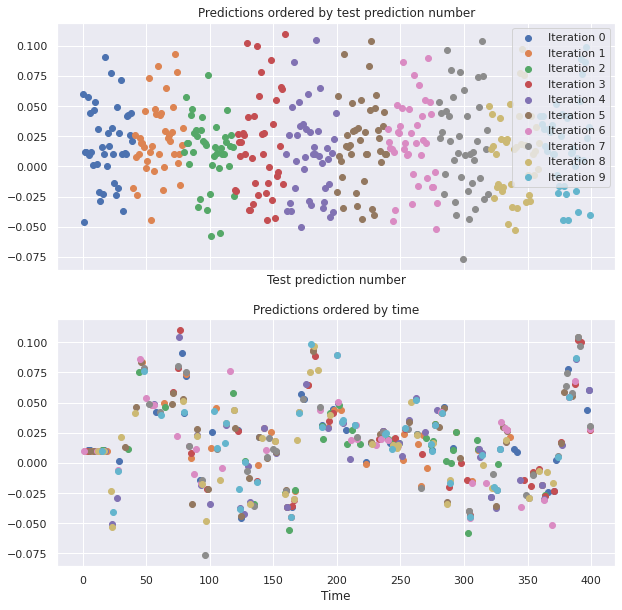

In [7]:
# Import ShuffleSplit and create the cross-validation object
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, random_state=1)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])
    
    # Generate predictions on the test data, score the predictions, and collect
    prediction = model.predict(X[tt])
    score = r2_score(y[tt], prediction)
    results.append((prediction, score, tt))

# Custom function to quickly visualize predictions
visualize_predictions(results)

The order of datapoints in the test set is scrambled. 

# ***Cross-validation without shuffling***

Now, re-run your model fit using block cross-validation (without shuffling all datapoints). In this case, neighboring time-points will be kept close to one another. How do you think the model predictions will look in each cross-validation loop?

An instance of the Linear regression `model` object is available in your workspace. Also, the arrays `X` and `y` (training data) are available too.

* Instantiate another cross-validation object, this time using **`KFold`** cross-validation with `10` splits and no shuffling.

* Iterate through this object to fit a model using the training indices and generate predictions using the test indices.

* Visualize the predictions across CV splits using the helper function (`visualize_predictions()`) we've provided.

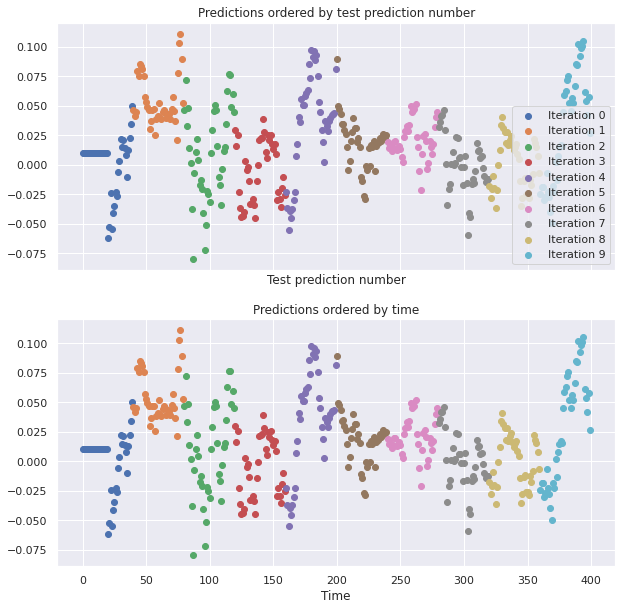

In [10]:
def visualize_predictions(results):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    # Loop through our model results to visualize them
    for ii, (prediction, indices) in enumerate(results):
        # Plot the predictions of the model in the order they were generated
        offset = len(prediction) * ii
        axs[0].scatter(np.arange(len(prediction)) + offset, prediction, label='Iteration {}'.format(ii))
        
        # Plot the predictions of the model according to how time was ordered
        axs[1].scatter(indices, prediction)
    axs[0].legend(loc="best")
    axs[0].set(xlabel="Test prediction number", title="Predictions ordered by test prediction number")
    axs[1].set(xlabel="Time", title="Predictions ordered by time")
    plt.show()

# Create KFold cross-validation object
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, shuffle=False)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])
    
    # Generate predictions on the test data and collect
    prediction = model.predict(X[tt])
    results.append((prediction, tt))
    
# Custom function to quickly visualize predictions
visualize_predictions(results)

This time, the predictions generated within each CV loop look 'smoother' than they were before - they look more like a real time series because you didn't shuffle the data. This is a good sanity check to make sure your CV splits are correct.

# ***Time-based cross-validation***

Finally, let's visualize the behavior of the time series cross-validation iterator in scikit-learn. Use this object to iterate through your data one last time, visualizing the training data used to fit the model on each iteration.

An instance of the Linear regression `model` object is available in your workpsace. Also, the arrays `X` and `y` (training data) are available too.

* Import **`TimeSeriesSplit`** from **`sklearn.model_selection`**.
* Instantiate a time series cross-validation iterator with `10` splits.
* Iterate through CV splits. On each iteration, visualize the values of the input data that would be used to train the model for that iteration.

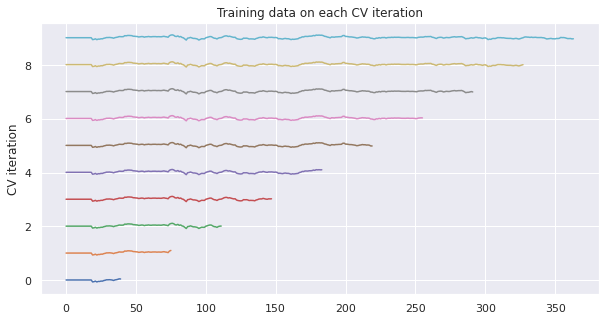

In [11]:
# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=10)

# Iterate through CV splits
fig, ax = plt.subplots(figsize=(10, 5))
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii + y[tr])

ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()

Note that the size of the training set grew each time when you used the time series cross-validation object. This way, the time points you predict are always *after* the timepoints we train on.

# ***Stationarity***

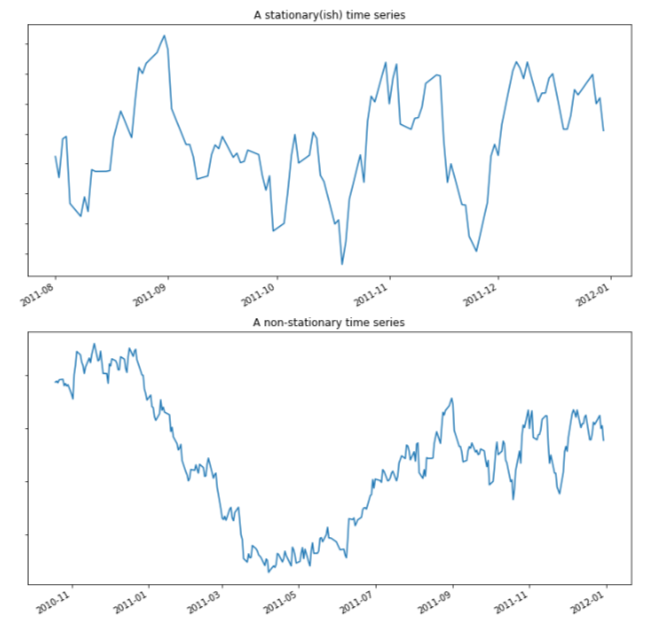

# ***Bootstrapping the mean***

In [ ]:
from sklearn.utils import resample

# cv_coefficients has shape (n_cv_folds, n_coefficients)
n_boots = 100
bootstrap_means = np.zeros(n_boots, n_coefficients)

for ii in range(n_boots):
    # Generate random indices for our data with replacement, then take the sample mean
    random_sample = resample(cv_coefficients)
    bootstrap_means[ii] = random_sample.mean(axis=0)
    
# Compute the percentiles of choice for the bootstrapped means
percentiles = np.percentile(bootstrap_means, (2.5, 97.5), axis=0)

# ***Plotting the bootstrapped coefficients***

In [ ]:
fig, ax = plt.subplots()
ax.scatter(many_shifts.columns, percentiles[0], marker='_', s=200)
ax.scatter(many_shifts.columns, percentiles[1], marker='_', s=200)

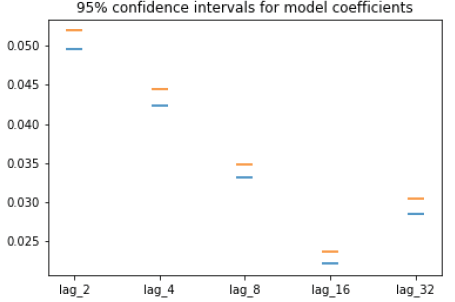

# ***Model performance over time***

In [ ]:
def my_corrcoef(est, X, y):
    """Return the correlation coefficient
    between model predictions and a validation set."""
    return np.corrcoef(y, est.predict(X))[1, 0]

# Grab the date of the first index of each validation set
first_indices = [data.index[tt[0]] for tr, tt in cv.split(X, y)]

# Calculate the CV scores and convert to a Pandas Series
cv_scores = cross_val_score(model, X, y, cv=cv, scoring=my_corrcoef)
cv_scores = pd.Series(cv_scores, index=first_indices)

# ***Visualizing model scores as a timeseries***

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Calculate a rolling mean of scores over time
cv_scores_mean = cv_scores.rolling(10, min_periods=1).mean()
cv_scores.plot(ax=axs[0])
axs[0].set(title='Validation scores (correlation)', ylim=[0, 1])

# Plot the raw data
data.plot(ax=axs[1])
axs[1].set(title='Validation data')

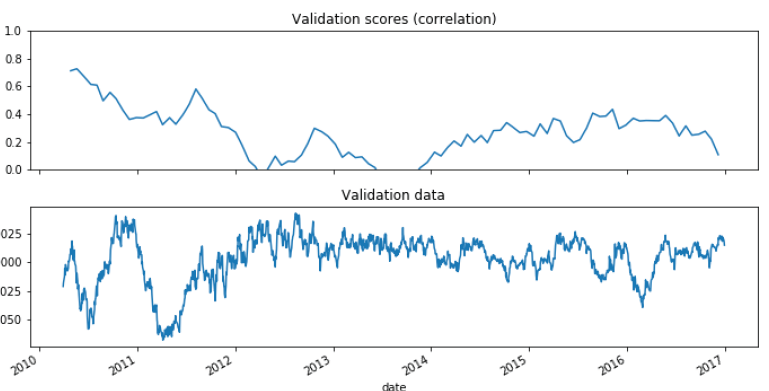

# ***Fixed windows with time series cross-validation***

In [ ]:
# Only keep the last 100 datapoints in the training data
window = 100

# Initialize the CV with this window size
cv = TimeSeriesSplit(n_splits=10, max_train_size=window)

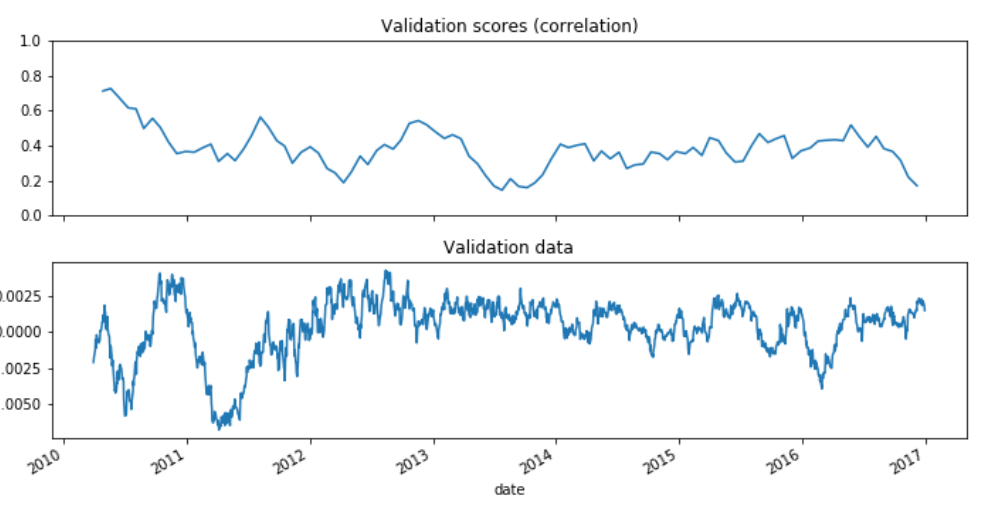

จะเห็นว่า ค่าสัมประสิทธิ์สหสัมพันธ์ดีขึ้นนิดหน่อย จากที่ตกไปตรงกลาง



### ***Bootstrapping a confidence interval***

A useful tool for assessing the variability of some data is the bootstrap. Write your own bootstrapping function that can be used to return a bootstrapped confidence interval.

This function takes three parameters: 
  * a 2-D array of numbers (`data`), 
  * a list of percentiles to calculate (`percentiles`), and 
  * the number of boostrap iterations to use (`n_boots`). 
  
It uses the **`resample`** function to generate a bootstrap sample, and then repeats this many times to calculate the confidence interval.

* The function should loop over the number of bootstraps (given by the parameter `n_boots`) and:

  * Take a random sample of the data, with replacement, and calculate the mean of this random sample
  * Compute the percentiles of `bootstrap_means` and return it

In [13]:
from sklearn.utils import resample

def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 2-D dataset."""
    # Create our empty array to fill the results
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)
        
    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles

You can use this function to assess the variability of your model coefficients.

### ***Calculating variability in model coefficients***

Re-run the cross-validation routine used before, but this time paying attention to the model's stability over time. You'll investigate the coefficients of the model, as well as the uncertainty in its predictions.

Begin by assessing the *stability* (or uncertainty) of a model's coefficients across multiple CV splits. Remember, the coefficients are a reflection of the pattern that your model has found in the data.

An instance of the Linear regression object (`model`) is available in your workpsace. Also, the arrays `X` and `y` (the data) are available too.


* Initialize a **`TimeSeriesSplit`** cross-validation object
* Create an array of all zeros to collect the coefficients.
* Iterate through splits of the cross-validation object. On each iteration:
  * Fit the `model` on training data
  * Collect the model's coefficients for analysis later

In [ ]:
# Iterate through CV splits
n_splits = 100
cv = TimeSeriesSplit(n_splits=n_splits)

# Create empty array to collect coefficients
coefficients = np.zeros([n_splits, X.shape[1]])

for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Fit the model on training data and collect the coefficients
    model.fit(X[tr], y[tr])
    coefficients[ii] = model.coef_



* Finally, calculate the 95% confidence interval for each coefficient in `coefficients` using the `bootstrap_interval()` function you defined in the previous exercise. 

In [ ]:
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(coefficients)

# Plot it
fig, ax = plt.subplots()
ax.scatter(feature_names, bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(feature_names, bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

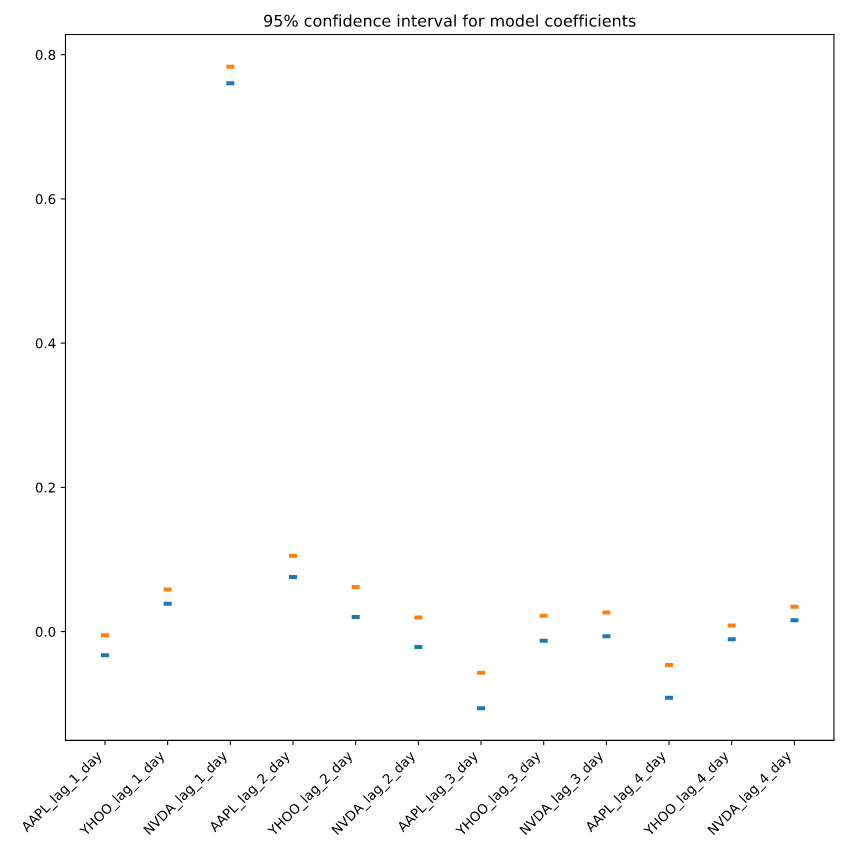

You've calculated the variability around each coefficient, which helps assess which coefficients are more stable over time.

### ***Visualizing model score variability over time***

Now that you've assessed the variability of each coefficient, let's do the same for the performance (scores) of the model. Recall that the **`TimeSeriesSplit`** object will use successively-later indices for each test set. This means that you can treat the scores of your validation as a time series. You can visualize this over time in order to see how the model's performance changes over time.

An instance of the Linear regression model object is stored in `model`, a cross-validation object in `cv`, and data in `X` and `y`.

* Calculate the cross-validated scores of the model on the data (using a custom scorer we defined for you, `my_pearsonr` along with `cross_val_score`).

* Convert the output scores into a pandas Series so that you can treat it as a time series.

* Bootstrap a rolling confidence interval for the mean score using `bootstrap_interval()`.

In [ ]:
from functools import partial
from sklearn.model_selection import cross_val_score

def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 1- or 2-D dataset."""
    # Create our empty array we'll fille with the results
    if data.ndim == 1:
        data = data[:, np.newaxis]
    data = np.atleast_2d(data)
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)

    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles

def my_pearsonr(est, X, y):
    return np.corrcoef(est.predict(X).squeeze(), y.squeeze())[1, 0]


# Generate scores for each split to see how the model performs over time
scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)

# Convert to a Pandas Series object
scores_series = pd.Series(scores, index=times_scores, name='score')

# Bootstrap a rolling confidence interval for the mean score
scores_lo = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=2.5))
scores_hi = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=97.5))

# Plot the results
fig, ax = plt.subplots()
scores_lo.plot(ax=ax, label="Lower confidence interval")
scores_hi.plot(ax=ax, label="Upper confidence interval")
ax.legend()
plt.show()

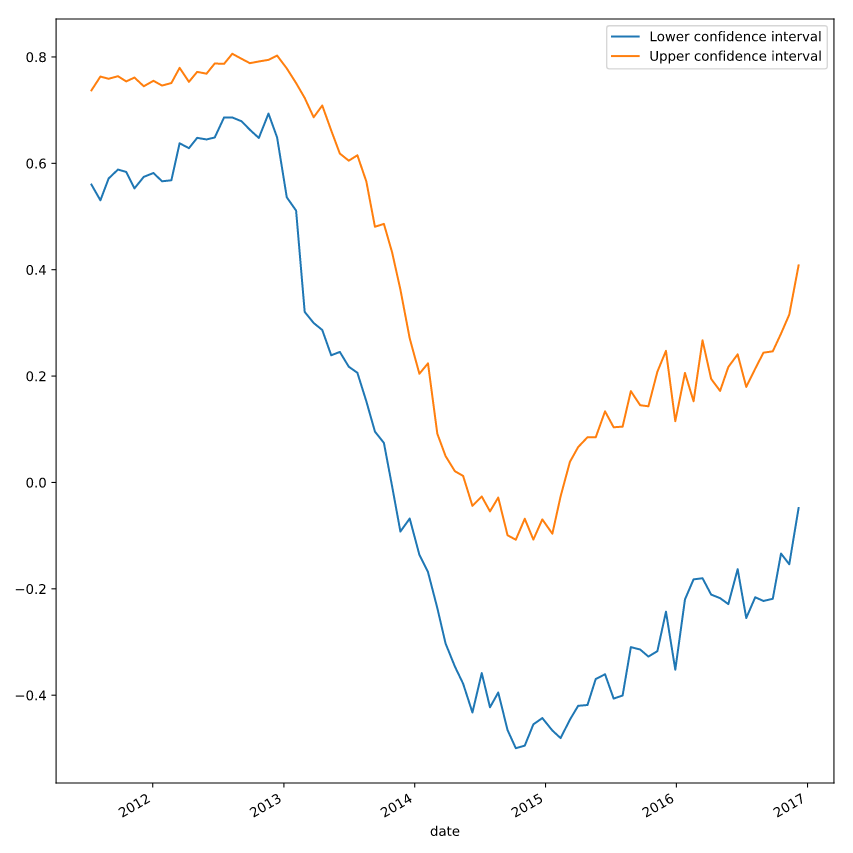

You plotted a rolling confidence interval for scores over time. This is useful in seeing when your model predictions are correct.

### ***Accounting for non-stationarity***

Visualize the variations in model scores, but now for data that changes its statistics over time.

An instance of the Linear regression `model` object is stored in `model`, a cross-validation object in `cv`, and the data in `X` and `y`.

* Create an empty DataFrame to collect the results.

* Iterate through multiple window sizes, each time creating a new `TimeSeriesSplit` object.

* Calculate the cross-validated scores (using a custom scorer we defined for you, `my_pearsonr`) of the model on training data.

In [ ]:
def my_pearsonr(est, X, y):
    return np.corrcoef(est.predict(X).squeeze(), y.squeeze())[1, 0]
times_scores = DatetimeIndex(['2010-04-05', '2010-04-28', '2010-05-21', '2010-06-16',
               '2010-07-12', '2010-08-04', '2010-08-27', '2010-09-22',
               '2010-10-15', '2010-11-09', '2010-12-03', '2010-12-29',
               '2011-01-24', '2011-02-16', '2011-03-14', '2011-04-06',
               '2011-05-02', '2011-05-25', '2011-06-20', '2011-07-14',
               '2011-08-08', '2011-08-31', '2011-09-26', '2011-10-19',
               '2011-11-11', '2011-12-07', '2012-01-03', '2012-01-27',
               '2012-02-22', '2012-03-16', '2012-04-11', '2012-05-04',
               '2012-05-30', '2012-06-22', '2012-07-18', '2012-08-10',
               '2012-09-05', '2012-09-28', '2012-10-23', '2012-11-19',
               '2012-12-13', '2013-01-09', '2013-02-04', '2013-02-28',
               '2013-03-25', '2013-04-18', '2013-05-13', '2013-06-06',
               '2013-07-01', '2013-07-25', '2013-08-19', '2013-09-12',
               '2013-10-07', '2013-10-30', '2013-11-22', '2013-12-18',
               '2014-01-14', '2014-02-07', '2014-03-05', '2014-03-28',
               '2014-04-23', '2014-05-16', '2014-06-11', '2014-07-07',
               '2014-07-30', '2014-08-22', '2014-09-17', '2014-10-10',
               '2014-11-04', '2014-11-28', '2014-12-23', '2015-01-20',
               '2015-02-12', '2015-03-10', '2015-04-02', '2015-04-28',
               '2015-05-21', '2015-06-16', '2015-07-10', '2015-08-04',
               '2015-08-27', '2015-09-22', '2015-10-15', '2015-11-09',
               '2015-12-03', '2015-12-29', '2016-01-25', '2016-02-18',
               '2016-03-14', '2016-04-07', '2016-05-02', '2016-05-25',
               '2016-06-20', '2016-07-14', '2016-08-08', '2016-08-31',
               '2016-09-26', '2016-10-19', '2016-11-11', '2016-12-07'],
              dtype='datetime64[ns]', name='date', freq=None)

cv = TimeSeriesSplit(max_train_size=100, n_splits=100)

##############

# Pre-initialize window sizes
window_sizes = [25, 50, 75, 100]

# Create an empty DataFrame to collect the stores
all_scores = pd.DataFrame(index=times_scores)

# Generate scores for each split to see how the model performs over time
for window in window_sizes:
    # Create cross-validation object using a limited lookback window
    cv = TimeSeriesSplit(n_splits=100, max_train_size=window)
    
    # Calculate scores across all CV splits and collect them in a DataFrame
    this_scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)
    all_scores['Length {}'.format(window)] = this_scores

# Visualize the scores
ax = all_scores.rolling(10).mean().plot(cmap=plt.cm.coolwarm)
ax.set(title='Scores for multiple windows', ylabel='Correlation (r)')
plt.show()

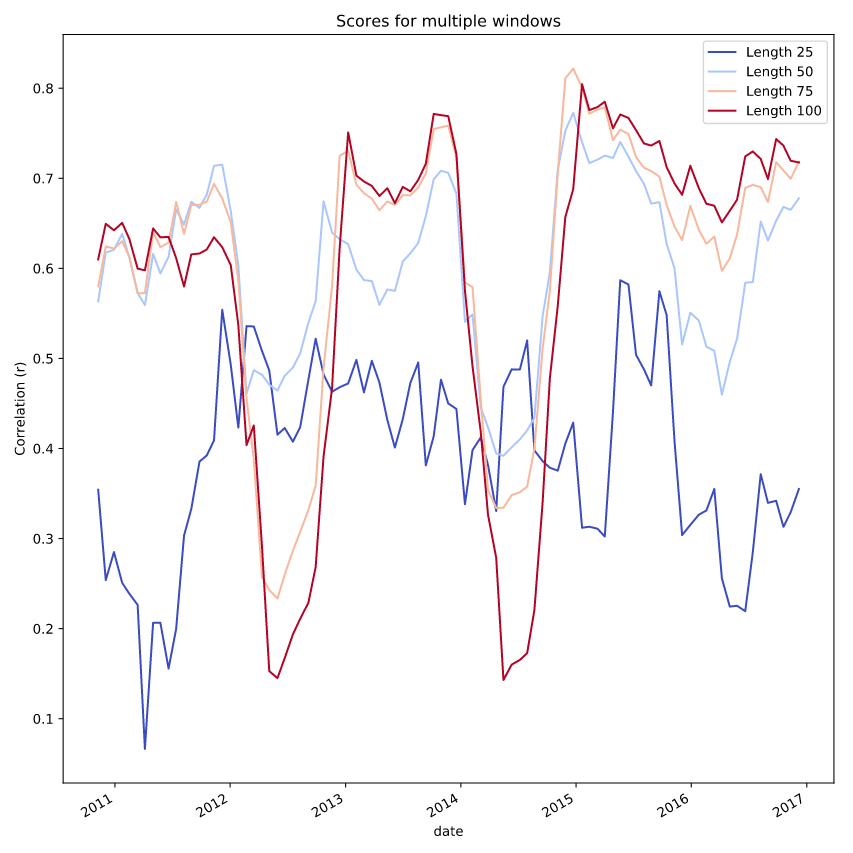

Notice how in some stretches of time, **longer** windows perform worse than shorter ones. This is because the statistics in the data have changed, and the longer window is now using outdated information.